In [11]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [12]:
import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [13]:
# statistics
from scipy.optimize import curve_fit
from scipy import stats

In [14]:
# some api for the file operation
import h5py
from tenpy.tools import hdf5_io
import os.path
# data path
prefix = 'data/'

In [15]:
from kitaev_ladder import KitaevLadderModel

## Now we define the function for calculating the ground energy and ground wave functions when the bond dimensions are given with specified Hamiltonian parameters

In [5]:
def run_atomic(
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=1, 
    verbose=1, 
    calc_correlation=True,
):

    #######################
    # set the paramters for model initialization
    model_params = dict(conserve=None, Jx=Jx, Jy=Jy, Jz=Jz, L=L, verbose=verbose)
    # providing a product state as the initial state
    prod_state = ["up", "up"] * (2 * model_params['L'])
    # initialize the model
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )
    #######################

    
    #######################
    # set the parameters for the dmrg routine
    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-6,
        'max_S_err': 1.e-4,
        'max_sweeps': 1000,
        'verbose': verbose,
    }
    #######################
    
    if verbose:
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')

    # here we create another new engine for every new chi
    # this is quite unusual but since some strange issues
    # we can only treat like this
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    eng.reset_stats()
    eng.trunc_params['chi_max'] = chi
    info = eng.run()
#         print("INFO: \n", info)

    if verbose:
        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)

        print("Canonicalizing...")
        psi_before = psi.copy()

    psi.canonical_form()

    if verbose:
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)

        print("Computing properties")

    energy=info[0]

    if verbose:
        print("Optimizing")

    tenpy.tools.optimization.optimize(3)

    if verbose:
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        
    return (energy, psi.copy())


In [6]:
def run(
    chi_list = [int(2**i) for i in np.arange(4, 7, 1)],
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=1, 
    verbose=1, 
    calc_correlation=True,
):

    #######################
    # set the paramters for model initialization
    model_params = dict(conserve=None, Jx=Jx, Jy=Jy, Jz=Jz, L=L, verbose=verbose)
    # providing a product state as the initial state
    prod_state = ["up", "up"] * (2 * model_params['L'])
    # initialize the model
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )
    #######################

    
    #######################
    # set the parameters for the dmrg routine
    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-8,
        'max_sweeps': 1000,
        'verbose': verbose,
    }
    #######################
    
    
    # we will return this data dictionary in the end, for the further investigation
    data = dict(
        chi_list=[],
        energy_list=[], 
        psi_list=[],
#         entropy_list=[], 
#         correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
#     chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        if verbose:
            print("\n")
            print("=" * 80)
            print("="*30 + "START" + "="*30)
            print("=" * 80)
            print("Chi = ", chi, '\n')
        
        # here we create another new engine for every new chi
        # this is quite unusual but since some strange issues
        # we can only treat like this
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        if verbose:
            print("Before the canonicalization:")
            print("Bond dim = ", psi.chi)

            print("Canonicalizing...")
            psi_before = psi.copy()
            
        psi.canonical_form()
        
        if verbose:
            ov = psi.overlap(psi_before, charge_sector=0)
            print("The norm is: ",psi.norm)
            print("The overlap is: ", ov)
            print("After the canonicalization:")
            print("Bond dim = ", psi.chi)

            print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        data['psi_list'].append(psi.copy())
        
#         entropy = np.mean(psi.entanglement_entropy())
#         data['entropy_list'].append(entropy)
        
#         if calc_correlation:
#             correlation = psi.correlation_length()
#             data['correlation_list'].append(correlation)
        
        if verbose:
            print("Optimizing")
            
        tenpy.tools.optimization.optimize(3)
        
        if verbose:
            print("Loop for chi=%d done." % chi)
            print("=" * 80)
            print("="*30 + " END " + "="*30)
            print("=" * 80)
            
        pass # end of the for loop
        
    return data


In [7]:
def run_more(
    chi_list = [int(2**i) for i in np.arange(4, 7, 1)],
    Jx_list=[1.], 
    Jy_list=[1.], 
    Jz_list=[0.], 
    L=1, 
    verbose=1, 
):
    data_set = [[[run(chi_list=chi_list, Jx=Jx, Jy=Jy, Jz=Jz, L=L, verbose=verbose,) for Jx in Jx_list] for Jy in Jy_list] for Jz in Jz_list]
    return data_set

In [8]:
def plot_results(data):

    chi_list = data['chi_list']
    energy_list = data['energy_list']
    entropy_list = data['entropy_list']
    correlation_list = data['correlation_list']
    
    plt.plot(chi_list, energy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Ground Energy $E$")
    plt.show()
    
    plt.plot(chi_list, entropy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    
    plt.plot(chi_list, correlation_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Correlation Length $\xi$")
    plt.show()
    
    plt.plot(np.log(correlation_list), entropy_list, '-o')
    plt.xlabel(r"log Correlation Length $\xi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()

In [9]:
def naming(chi, Jx, Jy, Jz, L):
    return "KitaevLadder"+"_chi_"+str(chi)+"_Jx_"+str(Jx)+"_Jy_"+str(Jy)+"_Jz_"+str(Jz)+"_L_"+str(L)

def full_path(chi, Jx, Jy, Jz, L):
    return prefix+naming(chi, Jx, Jy, Jz, L)+".h5"
""" run the atomic and then save it
"""
def run_save(
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=1, 
    verbose=1, 
    calc_correlation=True,
):
    file_name = full_path(chi, Jx, Jy, Jz, L)
    
    # if the file already existed then don't do the computation again
    if os.path.isfile(file_name):
        print("This file already existed")
    else:
        (energy, psi) = run_atomic(
            chi=chi, 
            Jx=Jx, 
            Jy=Jy, 
            Jz=Jz, 
            L=L, 
            verbose=verbose, 
            calc_correlation=calc_correlation,
        )
        data = {
            "psi": psi,
            "energy": energy,
            "parameters": {
                "chi": chi,
                "Jx": Jx,
                "Jy": Jy,
                "Jz": Jz,
                "L": L,
            }
        }
        with h5py.File(file_name, 'w') as f:
            hdf5_io.save_to_hdf5(f, data)
    pass

def read_psi(
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=1, 
):
    file_name = full_path(chi, Jx, Jy, Jz, L)
    with h5py.File(file_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        # or for partial reading:
        psi = hdf5_io.load_from_hdf5(f, "/psi")
        return psi
    
def read_energy(
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=1, 
):
    file_name = full_path(chi, Jx, Jy, Jz, L)
    with h5py.File(file_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        # or for partial reading:
        energy = hdf5_io.load_from_hdf5(f, "/energy")
        return energy
    
def read_parameters(
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=1, 
):
    file_name = full_path(chi, Jx, Jy, Jz, L)
    with h5py.File(file_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        # or for partial reading:
        parameters = hdf5_io.load_from_hdf5(f, "/parameters")
        return parameters

In [26]:
run_atomic()

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=1.0 for KitaevLadderModel
parameter 'Jz'=0.0 for KitaevLadderModel


==============================START==============================
Chi =  30 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591368440732928, S = nan, norm_err = 2.7e-03
Current memory usage 230.5 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9711e-08, max_E_trunc = 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
DMRG finished after 110 sweeps.
total size = 1484, maximum chi = 30
Before the canonicalization:
Bond dim =  [30, 30, 30, 30]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000018683506+5.11352069721747e-17j)
After the canonicalization:
Bond dim =  [30, 30, 30, 30]
Computing properties
Optimizing
Loop for chi=30 done.
============================== END ==============================


(-0.15915174425003542, <tenpy.networks.mps.MPS at 0x7f6e400c4050>)

In [25]:
run_save()
print(read_psi())

This file already existed
MPS, L=4, bc='infinite'.
chi: [30, 30, 30, 30]
sites: SpinHalfSite(None) SpinHalfSite(None) SpinHalfSite(None) SpinHalfSite(None)
forms: (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0)


## Run and get the data pack

Here we individually run the function and return the data.
No matter how the other parts are designed, this process needs to be seperate since it consumes the majority of resources.

In [10]:
# data = run(chi_list=range(30, 60, 2), verbose=0)

## Regional run and multiprocessing

In [12]:
import multiprocessing

In [13]:
# region selection
Jx_list = [1.]
Jy_list = np.arange(-2, 2, 1)
Jz_list = np.arange(-2, 2, 1)
chi_list = range(30, 60, 2)
J_list = [(Jx, Jy, Jz, chi) for Jx in Jx_list for Jy in Jy_list for Jz in Jz_list for chi in chi_list]

# prepare other arguments
verbose = 1

In [15]:
# here the 'point' refers to the point in the parameter space J=(J_x, J_y, J_z)
def run_at_single_point(J):
    assert (len(J) == 4)
    return run_save(chi=J[3], Jx=J[0], Jy=J[1], Jz=J[2], verbose=verbose)

In [18]:
# # multiprocessing preparation
# cores = int(multiprocessing.cpu_count() / 2)
# pool = multiprocessing.Pool(processes=cores)

# result = pool.map(run_at_single_point, J_list)

parameter 'verbose'=1 for KitaevLadderModel
parameter 'verbose'=1 for KitaevLadderModel
parameter 'verbose'=1 for KitaevLadderModel
parameter 'verbose'=1 for KitaevLadderModel
parameter 'verbose'=1 for KitaevLadderModel
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=

MPS bond dimensions: [40, 40, 40, 40]
...
sweep 10, age = 204
Energy = -0.2883149446474409, S = nan, norm_err = 8.4e-04
Current memory usage 151.8 MB, time elapsed: 146.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7913e-08, max_E_trunc = 8.6977e-08
MPS bond dimensions: [40, 40, 40, 40]
.
sweep 30, age = 444
Energy = -0.2658861023808186, S = 0.7849102485947688, norm_err = 1.3e-11
Current memory usage 148.6 MB, time elapsed: 148.0 s
Delta E = 5.6701e-13, Delta S = nan (per sweep)
max_trunc_err = 7.8273e-11, max_E_trunc = 3.4171e-10
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
....Updating environment
.
sweep 30, age = 444
Energy = -0.3610806594638234, S = 1.2075076237345381, norm_err = 9.8e-12
Current memory usage 147.7 MB, time elapsed: 165.6 s
Delta E = -2.7427e-13, Delta S = nan (per sweep)
max_trunc_err = 1.3815e-10, max_E_trunc = 5.1305e-10
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
......
sweep 40, age = 564
Energy = -0.2658861

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.The norm is:  1.0
The overlap is:  (0.9999999999999991+1.766436389522008e-16j)
After the canonicalization:
Bond dim =  [30, 30, 30, 25]
Computing properties
Optimizing
Loop for chi=30 done.
Updating environment
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  32 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
............
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
.parameter 'mixer'=True for Sweep

parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.The norm is:  1.0
The overlap is:  (0.999999962029554-3.4243590602001106e-11j)
After the canonicalization:
Bond dim =  [27, 29, 26, 30]
Computing properties
Optimizing
Loop for chi=30 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
Chi =  32 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..
Updating environment
sweep 20, age = 324
Energy = -0.3610806596741387, S = nan, norm_err = 2.1e-11
Current memory usage 158.9 MB, time elapsed: 205.3 s
Delta E = -4.3876e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8738e-13,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999991-3.1725434371338067e-16j)
After the canonicalization:
Bond dim =  [46, 50, 46, 34]
Computing properties
Optimizing
Loop for chi=50 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  52 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
......Updating environment
....
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'd

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.Updating environment
.
sweep 40, age = 564
Energy = -0.2883249508640588, S = 1.6184721211406468, norm_err = 1.9e-04
Current memory usage 152.6 MB, time elapsed: 288.5 s
Delta E = -3.6596e-08, Delta S = 1.5426e-03 (per sweep)
max_trunc_err = 6.8435e-07, max_E_trunc = 2.0413e-06
MPS bond dimensions: [40, 40, 40, 40]
..The norm is:  1.0
The overlap is:  (0.9999999999999987-2.791820594150174e-16j)
After the canonicalization:
Bond dim =  [40, 50, 40, 50]
Computing properties
Optimizing
Loop for chi=50 done.
============================== END ==============================
.parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel
.

==============================START==============================
Chi =  52 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} fo

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1-1.846661526934423e-16j)
After the canonicalization:
Bond dim =  [31, 32, 32, 27]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  34 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
.....Updating environment
..Updating environment
....
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.The norm is:  1.0
The overlap is:  (1.0000000000000022+2.0079424234431542e-16j)
After the canonicalization:
Bond dim =  [28, 32, 28, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
Chi =  34 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
.....
sweep 10, age = 204
Energy = -0.3610806596740055, S = nan, norm_err = 1.4e-11
Current memory usage 164.8 MB, time elapsed: 113.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2822e-13, max_E_trunc = 1.3571e-12

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.71e-05
Updating environment
...........
sweep 100, age = 1284
Energy = -0.2883251381278598, S = 1.6416145931452562, norm_err = 1.7e-05
Current memory usage 154.4 MB, time elapsed: 495.4 s
Delta E = -1.7007e-10, Delta S = 9.4872e-05 (per sweep)
max_trunc_err = 1.0261e-06, max_E_trunc = 2.9488e-06
MPS bond dimensions: [40, 40, 40, 40]


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.71e-05
Updating environment
.
Updating environment
.........
sweep 10, age = 204
Energy = -0.3610806595866398, S = nan, norm_err = 5.6e-10
Current memory usage 156.1 MB, time elapsed: 82.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0509e-10, max_E_trunc = 1.2651e-10
MPS bond dimensions: [34, 34, 34, 34]
...
Updating environment
.
DMRG finished after 100 sweeps.
total size = 1364, maximum chi = 40
Before the canonicalization:
Bond dim =  [40, 40, 40, 40]
Canonicalizing...
Updating environment
..........
DMRG finished after 100 sweeps.
total size = 1364, maximum chi = 40
Before the canonicalization:
Bond dim =  [40, 40, 40, 40]
Canonicalizing...
.
sweep 30, age = 444
Energy = -0.2658861024932868, S = 0.7849103279139003, norm_err = 1.9e-12
Current memory usage 168.4 MB, time elapsed: 233.3 s
Delta E = -2.4869e-15, Delta S = nan (per sweep)
max_trunc_err = 4.2525e-14, max_E_trunc = 1.8474e-13
MPS bond dimensions: [52, 52, 5

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Updating environment
Updating environment
The norm is:  1.0
.The overlap is:  (1.0000000000000049+2.635843207497857e-16j)
After the canonicalization:
Bond dim =  [46, 52, 46, 34]
Computing properties
.Optimizing
Loop for chi=52 done.
============================== END ==============================
...parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
.parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  54 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
......
.sweep 30, age = 444
Energy = -0.2658861024169585, S = 0.7849102683686046, norm_err = 3.8e-11
Current memory usage 156.9 MB, time elapsed: 168.6 s
Delta E = -3.8014e-14, Delta S = nan (

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.The norm is:  1.0
The overlap is:  (0.999999999999998+4.621777043177966e-17j)
After the canonicalization:
Bond dim =  [33, 34, 34, 27]
Computing properties
Optimizing
Loop for chi=34 done.
============================== END ==============================
.
Updating environment
sweep 30, age = 444
Energy = -0.3610806596293941, S = 1.2075077106962331, norm_err = 3.6e-12
Current memory usage 156.4 MB, time elapsed: 173.5 s
Delta E = -2.4656e-13, Delta S = nan (per sweep)
max_trunc_err = 4.4229e-11, max_E_trunc = 1.3446e-10
MPS bond dimensions: [34, 34, 34, 34]
.parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  36 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Init

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000002-8.847089727481716e-17j)
After the canonicalization:
Bond dim =  [41, 52, 40, 52]
Computing properties
Optimizing
Loop for chi=52 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
Chi =  54 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999726124389768-7.33649510031853e-08j)
After the canonicalization:
Bond dim =  [32, 24, 20, 28]
Computing properties
Optimizing
Loop for chi=34 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
Chi =  36 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
Updating environment
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'di

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999964+1.2637731573034161e-17j)
After the canonicalization:
Bond dim =  [34, 36, 34, 27]
Computing properties
Optimizing
Loop for chi=36 done.
============================== END ==============================
.parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  38 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
......Updating environment
.......
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000027+8.595145898457457e-17j)
After the canonicalization:
Bond dim =  [46, 54, 46, 34]
Computing properties
Optimizing
Loop for chi=54 done.
============================== END ==============================
Updating environment
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  56 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
...........
sweep 40, age = 564
Energy = -0.3610806596700726, S = 1.2075077443976661, norm_err = 9.9e-13
Current memory usage 157.4 MB, time elapsed: 213.0 s
Delta E = -7.1054e-15, Delta S = -1.5729e-11 (per sweep)
max_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


..Updating environment

sweep 50, age = 684
Energy = -0.2883252916008665, S = 1.6307619469046828, norm_err = 1.2e-04
Current memory usage 161.0 MB, time elapsed: 331.0 s
Delta E = -1.3281e-08, Delta S = 9.9706e-04 (per sweep)
max_trunc_err = 6.5671e-07, max_E_trunc = 2.0839e-06
MPS bond dimensions: [42, 42, 42, 42]
.The norm is:  1.0
The overlap is:  (0.0005483632484578202+0.0013426452776722293j)
After the canonicalization:
Bond dim =  [18, 20, 18, 19]
Computing properties
Optimizing
Loop for chi=36 done.
============================== END ==============================
..parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
Chi =  38 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


....The norm is:  1.0
Updating environment
The overlap is:  (0.9999999999999988+6.2426328212641935e-18j)
After the canonicalization:
Bond dim =  [40, 54, 40, 54]
Computing properties
Optimizing
Loop for chi=54 done.
============================== END ==============================
.
.================================================================================
sweep 70, age = 924
Energy = -0.2883253534356669, S = 1.6414813988147086, norm_err = 6.2e-05
Current memory usage 162.5 MB, time elapsed: 400.6 s
Delta E = -1.9151e-09, Delta S = 4.0698e-04 (per sweep)
max_trunc_err = 7.7450e-07, max_E_trunc = 2.4744e-06
MPS bond dimensions: [42, 42, 42, 42]
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel
.

==============================START==============================
Chi =  56 

parameter

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999998-2.1787714326753605e-16j)
After the canonicalization:
Bond dim =  [37, 38, 36, 28]
Computing properties
Optimizing
Loop for chi=38 done.
============================== END ==============================
Updating environment
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  40 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........Updating environment
..
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.42e-05
Updating environment
.Updating environment
.....
..================================================================================
sweep 20, age = 324
Energy = -0.2658861024932939, S = nan, norm_err = 4.8e-10
Current memory usage 172.4 MB, time elapsed: 213.5 s
Delta E = -9.8330e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4169e-13, max_E_trunc = 3.6238e-13
MPS bond dimensions: [56, 56, 56, 54]
Convergence criterium reached with enabled mixer.
disable mixer and continue
..
DMRG finished after 110 sweeps.
total size = 1444, maximum chi = 42
Before the canonicalization:
Bond dim =  [42, 42, 42, 42]
Canonicalizing...
.
sweep 110, age = 1404
Energy = -0.2883253681669160, S = 1.6479637433346135, norm_err = 1.4e-05
Current memory usage 162.7 MB, time elapsed: 540.2 s
Delta E = -8.1764e-11, Delta S = 7.9293e-05 (per sweep)
max_trunc_err = 8.5054e-07, max_E_trunc = 2.6978e-06
MPS bond dimensions: [42, 42, 42, 42]


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.37e-05
Updating environment
.....
DMRG finished after 110 sweeps.
total size = 1444, maximum chi = 42
Before the canonicalization:
Bond dim =  [42, 42, 42, 42]
Canonicalizing...
Updating environment
.The norm is:  1.0
The overlap is:  (1.0000000073124211-5.946645974771598e-16j)
After the canonicalization:
Bond dim =  [42, 42, 42, 42]
Computing properties
Optimizing
Loop for chi=42 done.
============================== END ==============================
..parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=1 for KitaevLadderModel


==============================START==============================
Chi =  44 
.
parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-1 for KitaevLadderModel
.
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG

parameter 'max_S_err'=0.0001 for DMRG

parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
==============================START==============================
Chi =  44 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
.The norm is:  1.0
The overlap is:  (0.9999999735142795-1.0375267225221085e-10j)
After the canonicalization:
Bond dim =  [36, 35, 32, 38]
Computing properties
Optimizing
Loop for chi=38 done.
.===============================================================

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.The norm is:  1.0
The overlap is:  (1.0000000000000049+3.085101897475321e-16j)
After the canonicalization:
Bond dim =  [46, 56, 46, 34]
Computing properties
Optimizing
Loop for chi=56 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  58 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
...........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} f

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)


.
sweep 10, age = 204
Energy = -0.2883153042140956, S = nan, norm_err = 9.2e-04
Current memory usage 163.6 MB, time elapsed: 149.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6708e-08, max_E_trunc = 6.7864e-08
MPS bond dimensions: [44, 44, 44, 44]


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)


.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.The norm is:  1.0
The overlap is:  (0.9368411752961174-5.0707268245409054e-14j)
After the canonicalization:
Bond dim =  [22, 40, 42, 40]
Computing properties
Optimizing
Loop for chi=56 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
.Chi =  58 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
............
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 3

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000024-4.41609097380502e-17j)
After the canonicalization:
Bond dim =  [38, 40, 38, 28]
Computing properties
Optimizing
Loop for chi=40 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  42 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.The norm is:  1.0
The overlap is:  (0.7753817672194722-6.510956712650696e-14j)
After the canonicalization:
Bond dim =  [20, 36, 40, 36]
Computing properties
Optimizing
Loop for chi=40 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


.================================================================================
==============================START==============================
Chi =  42 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
.......
sweep 20, age = 324
Energy = -0.2883234829711103, S = nan, norm_err = 5.3e-04
Current memory usage 165.2 MB, time elapsed: 236.3 s
Delta E = -8.1788

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Updating environment
.The norm is:  1.0
The overlap is:  (0.9999999999999948-3.476037722347235e-16j)
After the canonicalization:
Bond dim =  [46, 58, 46, 34]
.Computing properties
Optimizing
Loop for chi=58 done.
============================== END ==============================
.Updating environment
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=1 for KitaevLadderModel


==============================START==============================
Chi =  30 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
....
sweep 60, age = 804
Energy = -0.2883257810883677, S = 1.6460437636975294, norm_err = 1.2e-04
Current memory usage 165.0 MB, time elapsed: 370.7 s
Delta E = -8.1195e-09, Delta S = 9.0098e-04 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000022+7.373183122236697e-18j)
After the canonicalization:
Bond dim =  [40, 42, 40, 29]
Computing properties
Optimizing
Loop for chi=42 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  44 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


...Updating environment
The norm is:  1.0
The overlap is:  (0.9999999999999998+1.8016390788098968e-16j)
After the canonicalization:
Bond dim =  [40, 42, 40, 42]
Computing properties
Optimizing
.Loop for chi=42 done.
============================== END ==============================
..parameter 'verbose'=1 for KitaevLadderModel
.parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
Chi =  44 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..
sweep 90, age = 1164
Energy = -0.2883258424935207, S = 1.6595589551507179, norm_err = 4.3e-05
Current memory usage 165.4 MB, time elapsed: 476.3 s
Delta E = -7.9768e-10, Delta S = 3.1290e-04 (per sweep)
max_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1+7.871307772244762e-17j)
After the canonicalization:
Bond dim =  [43, 58, 43, 58]
Computing properties
Optimizing
Loop for chi=58 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-1 for KitaevLadderModel


==============================START==============================
Chi =  30 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
.......Updating environment
...
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.10e-05
Updating environment
...Updating environment
......
DMRG finished after 130 sweeps.
total size = 1684, maximum chi = 44
Before the canonicalization:
Bond dim =  [44, 44, 44, 44]
Canonicalizing...
.
.sweep 10, age = 204
Energy = -0.2883117364912584, S = nan, norm_err = 5.8e-04
Current memory usage 175.3 MB, time elapsed: 105.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5367e-06, max_E_trunc = 2.2121e-06
MPS bond dimensions: [30, 30, 30, 30]
..
sweep 130, age = 1644
Energy = -0.2883258486192233, S = 1.6656751011694213, norm_err = 1.1e-05
Current memory usage 165.7 MB, time elapsed: 602.5 s
Delta E = -1.6772e-11, Delta S = 9.0730e-05 (per sweep)
max_trunc_err = 6.1748e-07, max_E_trunc = 1.7806e-06
MPS bond dimensions: [44, 44, 44, 44]


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.10e-05
Updating environment
..Updating environment
.....
DMRG finished after 130 sweeps.
total size = 1684, maximum chi = 44
Before the canonicalization:
Bond dim =  [44, 44, 44, 44]
Canonicalizing...
...
sweep 50, age = 684
Energy = -0.2883208504533030, S = 1.5980237194074993, norm_err = 3.6e-05
Current memory usage 174.4 MB, time elapsed: 240.1 s
Delta E = -1.1035e-09, Delta S = 4.2717e-04 (per sweep)
max_trunc_err = 2.3993e-06, max_E_trunc = 7.0677e-06
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
....The norm is:  1.0
The overlap is:  (1.0000000053456346-8.326672684688674e-17j)
After the canonicalization:
Bond dim =  [44, 44, 44, 44]
Computing properties
Optimizing
Loop for chi=44 done.
============================== END ==============================
.
sweep 30, age = 444
Energy = -0.2658861024797350, S = 0.7849103094134324, norm_err = 1.1e-12
Current memory usage 165.1 MB, time elapsed: 192.5 s
Delta E = -2.3407e-09, Delta S 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999989-9.506005930661375e-17j)
After the canonicalization:
Bond dim =  [42, 44, 42, 31]
Computing properties
Optimizing
Loop for chi=44 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  46 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..Updating environment
............
.
parameter 'max_sweeps'=1000 for DMRG
sweep 70, age = 924
Energy = -0.2883208463977418, S = 1.6011943191449762, norm_err = 2.7e-05
Current memory usage 174.4 MB, time elapsed: 291.6 s
Delta E = 3.8450e-1

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=4.24e-05
Updating environment
.....
Updating environment
...Updating environment
...
Updating environment
.......
.sweep 40, age = 564
Energy = -0.3610806596735969, S = 1.2075077472017275, norm_err = 9.6e-14
Current memory usage 166.2 MB, time elapsed: 219.1 s
Delta E = -4.9738e-15, Delta S = 6.5792e-14 (per sweep)
max_trunc_err = 3.4776e-13, max_E_trunc = 2.8137e-12
MPS bond dimensions: [44, 44, 44, 44]
DMRG finished after 40 sweeps.
total size = 564, maximum chi = 44
Before the canonicalization:
Bond dim =  [44, 44, 44, 44]
Canonicalizing...
.
DMRG finished after 80 sweeps.
total size = 1164, maximum chi = 30
Before the canonicalization:
Bond dim =  [30, 30, 30, 30]
Canonicalizing...
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)


.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


...
sweep 40, age = 564
Energy = -0.2883208438229481, S = 1.5938506648123361, norm_err = 8.3e-05
Current memory usage 175.3 MB, time elapsed: 211.6 s
Delta E = -1.2405e-08, Delta S = 9.1116e-04 (per sweep)
max_trunc_err = 2.2680e-06, max_E_trunc = 6.8848e-06
MPS bond dimensions: [30, 30, 30, 30]The norm is:  1.0

The overlap is:  (0.8048139793565334-8.634734869470537e-14j)
After the canonicalization:
Bond dim =  [20, 38, 40, 40]
Computing properties
Optimizing
Loop for chi=44 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
Chi =  46 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps..

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=4.37e-05
Updating environment
......
Updating environment
......
sweep 10, age = 204
Energy = -0.2883143774098365, S = nan, norm_err = 8.2e-04
Current memory usage 174.6 MB, time elapsed: 104.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7945e-07, max_E_trunc = 2.8502e-07
MPS bond dimensions: [32, 32, 32, 32]
...
Updating environment
......
DMRG finished after 80 sweeps.
total size = 1164, maximum chi = 30
Before the canonicalization:
Bond dim =  [30, 30, 30, 30]
Canonicalizing...
.
sweep 20, age = 324
Energy = -0.2658861024762729, S = nan, norm_err = 2.1e-09
Current memory usage 166.4 MB, time elapsed: 170.2 s
Delta E = -1.0020e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8520e-11, max_E_trunc = 7.0784e-11
MPS bond dimensions: [46, 46, 45, 45]
Convergence criterium reached with enabled mixer.
disable mixer and continue
The norm is:  1.0
The overlap is:  (0.9999999965980241-3.5220378692652706e-16j)
After the can

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.
sweep 30, age = 444
Energy = -0.2883231593031930, S = 1.5925461889859647, norm_err = 2.0e-04
Current memory usage 174.6 MB, time elapsed: 191.6 s
Delta E = -1.0058e-07, Delta S = nan (per sweep)
max_trunc_err = 1.0289e-06, max_E_trunc = 2.6299e-06
MPS bond dimensions: [32, 32, 32, 32]
.
sweep 30, age = 444
Energy = -0.2883251123769774, S = 1.6073556326526937, norm_err = 3.5e-04
Current memory usage 168.6 MB, time elapsed: 281.3 s
Delta E = -1.5455e-07, Delta S = nan (per sweep)
max_trunc_err = 2.2052e-07, max_E_trunc = 7.2458e-07
MPS bond dimensions: [46, 46, 46, 46]
The norm is:  1.0
The overlap is:  (1.0000000000000007-3.766905644551173e-17j)
After the canonicalization:
Bond dim =  [44, 46, 44, 32]
Computing properties
Optimizing
Loop for chi=46 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderMod

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1-1.4387362828882644e-16j)
After the canonicalization:
Bond dim =  [40, 46, 40, 46]
Computing properties
Optimizing
Loop for chi=46 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=-2 for KitaevLadderModel


==============================START==============================
Chi =  48 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
....Updating environment
........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
.parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


....
sweep 70, age = 924
Energy = -0.2883259399286437, S = 1.6546594891319857, norm_err = 7.9e-05
Current memory usage 168.6 MB, time elapsed: 439.5 s
Delta E = -4.9812e-09, Delta S = 6.0217e-04 (per sweep)
max_trunc_err = 4.3902e-07, max_E_trunc = 1.3801e-06
MPS bond dimensions: [46, 46, 46, 46]
.The norm is:  1.0
The overlap is:  (0.9999999981516612-5.388531973134113e-15j)
After the canonicalization:
Bond dim =  [30, 32, 31, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-2 for KitaevLadderModel
parameter 'Jz'=1 for KitaevLadderModel


==============================START==============================
Chi =  34 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


..The norm is:  1.0
The overlap is:  (0.9999999999999951+2.358173106126527e-16j)
After the canonicalization:
Bond dim =  [46, 48, 46, 34]
.Computing properties
Optimizing
Loop for chi=48 done.
============================== END ==============================
.This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
This file already existed
.This file already existed

This file 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Updating environment
.The norm is:  1.0
The overlap is:  (0.9055078933609008-1.551705812452564e-13j)
After the canonicalization:
Bond dim =  [20, 38, 40, 38]
Computing properties
Optimizing
Loop for chi=48 done.
============================== END ==============================
..This file already existed
This file already existed
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-1 for KitaevLadderModel
parameter 'Jz'=0 for KitaevLadderModel


==============================START==============================
Chi =  54 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
.....
sweep 120, age = 1524
Energy = -0.2883259881286477, S = 1.6698504434324146, norm_err = 3.8e-05
Current memory usage 168.6 MB, time elapsed: 635.8 s
Delta E = 

MPS bond dimensions: [34, 34, 34, 34]
...
sweep 10, age = 204
Energy = -0.1591375630045255, S = nan, norm_err = 3.2e-03
Current memory usage 171.5 MB, time elapsed: 125.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5125e-10, max_E_trunc = 4.0077e-10
MPS bond dimensions: [54, 54, 54, 53]
Updating environment
Updating environment
Updating environment
.......
sweep 60, age = 804
Energy = -0.2883237817824487, S = 1.6147054195088533, norm_err = 6.3e-05
Current memory usage 174.8 MB, time elapsed: 329.8 s
Delta E = -1.1182e-09, Delta S = 2.9601e-04 (per sweep)
max_trunc_err = 1.1187e-06, max_E_trunc = 3.2693e-06
MPS bond dimensions: [34, 34, 34, 34]
......
sweep 20, age = 324
Energy = -0.2883224573748677, S = nan, norm_err = 4.3e-04
Current memory usage 175.3 MB, time elapsed: 196.0 s
Delta E = -7.8380e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2569e-07, max_E_trunc = 1.2934e-06
MPS bond dimensions: [34, 34, 34, 34]
Convergence criterium reached with enab

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=4.66e-05
Updating environment
.
sweep 10, age = 204
Energy = -0.2883152424672470, S = nan, norm_err = 9.5e-04
Current memory usage 169.9 MB, time elapsed: 160.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1311e-08, max_E_trunc = 4.0926e-08
MPS bond dimensions: [48, 48, 48, 48]
......
Updating environment
....Updating environment
...
Updating environment
.......
.================================================================================
sweep 40, age = 564
Energy = -0.2883237221628931, S = 1.6062129540423582, norm_err = 1.2e-04
Current memory usage 175.3 MB, time elapsed: 262.6 s
Delta E = -2.1501e-08, Delta S = 1.1054e-03 (per sweep)
max_trunc_err = 9.4286e-07, max_E_trunc = 2.7656e-06
MPS bond dimensions: [34, 34, 34, 34]
..
Updating environment
....disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
....
DMRG finished after 80 sweeps.
total size = 1204, maximum chi = 34
Before the canonical

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.49e-05
Updating environment
.....
.================================================================================
sweep 60, age = 804
Energy = -0.1591537844825819, S = 0.8888771437697305, norm_err = 3.7e-04
Current memory usage 169.5 MB, time elapsed: 419.8 s
Delta E = -1.2939e-08, Delta S = 1.9511e-03 (per sweep)
max_trunc_err = 3.6251e-07, max_E_trunc = 7.2435e-07
MPS bond dimensions: [46, 46, 46, 46]
...
sweep 30, age = 444
Energy = -0.2883252331701627, S = 1.6082250825269615, norm_err = 3.7e-04
Current memory usage 171.4 MB, time elapsed: 302.1 s
Delta E = -1.5889e-07, Delta S = nan (per sweep)
max_trunc_err = 1.4999e-07, max_E_trunc = 5.1751e-07
MPS bond dimensions: [48, 48, 48, 48]
....
sweep 30, age = 444
Energy = -0.1591528249819021, S = 0.8050925712807045, norm_err = 1.2e-03
Current memory usage 173.6 MB, time elapsed: 350.4 s
Delta E = -2.3651e-07, Delta S = nan (per sweep)
max_trunc_err = 8.6974e-08, max_E_trunc = 9.1964e-08
MPS bo

sweep 60, age = 804
Energy = -0.1591541016107527, S = 0.9023732473836372, norm_err = 4.5e-04
Current memory usage 173.6 MB, time elapsed: 473.2 s
Delta E = -1.5770e-08, Delta S = 2.2876e-03 (per sweep)
max_trunc_err = 1.8005e-07, max_E_trunc = 3.6591e-07
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
....Updating environment
.
sweep 30, age = 444
Energy = -0.2883239395677446, S = 1.5982977721484075, norm_err = 2.4e-04
Current memory usage 174.8 MB, time elapsed: 238.5 s
Delta E = -1.1440e-07, Delta S = nan (per sweep)
max_trunc_err = 6.2338e-07, max_E_trunc = 1.6704e-06
MPS bond dimensions: [36, 36, 36, 36]
.....
sweep 100, age = 1284
Energy = -0.1591538994726172, S = 0.9256996582891054, norm_err = 8.9e-05
Current memory usage 169.5 MB, time elapsed: 561.0 s
Delta E = -7.7804e-10, Delta S = 5.0063e-04 (per sweep)
max_trunc_err = 5.0503e-07, max_E_trunc = 9.9661e-07
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
....Updating environment
Updating environment
.
swe

MPS bond dimensions: [48, 48, 48, 48]
........

sweep 70, age = 924
Energy = -0.2883243181784891, S = 1.6245556887406634, norm_err = 2.5e-05
Current memory usage 174.8 MB, time elapsed: 370.8 s
Delta E = -4.6535e-10, Delta S = 2.2321e-04 (per sweep)
max_trunc_err = 1.0899e-06, max_E_trunc = 2.8399e-06
MPS bond dimensions: [36, 36, 36, 36]sweep 30, age = 444
Energy = -0.2883239436106635, S = 1.5984314714546068, norm_err = 2.4e-04
Current memory usage 175.3 MB, time elapsed: 234.5 s
Delta E = -1.1292e-07, Delta S = nan (per sweep)
max_trunc_err = 6.2567e-07, max_E_trunc = 1.6760e-06
MPS bond dimensions: [36, 36, 36, 36]

.Updating environment
.
sweep 100, age = 1284
Energy = -0.2883262498783381, S = 1.6744258211562582, norm_err = 4.3e-05
Current memory usage 171.9 MB, time elapsed: 571.3 s
Delta E = -6.9343e-10, Delta S = 3.0054e-04 (per sweep)
max_trunc_err = 3.1530e-07, max_E_trunc = 1.0145e-06
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.........
sweep 100, age = 1284
E

sweep 120, age = 1524
Energy = -0.1591542830485722, S = 0.9607680059077788, norm_err = 9.5e-05
Current memory usage 175.3 MB, time elapsed: 700.0 s
Delta E = -4.4917e-10, Delta S = 4.5604e-04 (per sweep)
max_trunc_err = 2.9345e-07, max_E_trunc = 6.0253e-07
MPS bond dimensions: [54, 54, 54, 54]
..
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-06 for DMRG
parameter 'max_S_err'=0.0001 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
The norm is:  1.0
The overlap is:  (1.0000000002602722+6.777534115742277e-17j)
After the canonicalization:
Bond dim =  [46, 46, 46, 46]
Computing properties
Optimizing
Loop for chi=46 done.
============================== END ==============================
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=-1 for KitaevLadderModel

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.30e-05
Updating environment
.......
sweep 80, age = 1044
Energy = -0.2883243189021698, S = 1.6258244166218829, norm_err = 1.4e-05
Current memory usage 175.3 MB, time elapsed: 394.7 s
Delta E = -7.0949e-11, Delta S = 1.2557e-04 (per sweep)
max_trunc_err = 1.1133e-06, max_E_trunc = 2.8997e-06
MPS bond dimensions: [36, 36, 36, 36]
.
sweep 140, age = 1764
Energy = -0.1591542871276772, S = 0.9669870236422902, norm_err = 5.6e-05
Current memory usage 175.6 MB, time elapsed: 776.0 s
Delta E = -1.4920e-10, Delta S = 2.7181e-04 (per sweep)
max_trunc_err = 3.1013e-07, max_E_trunc = 6.3590e-07
MPS bond dimensions: [54, 54, 54, 54]
...
Updating environment
.....
DMRG finished after 140 sweeps.
total size = 1844, maximum chi = 48
Before the canonicalization:
Bond dim =  [48, 48, 48, 48]
Canonicalizing...
Updating environment
..Updating environment
.Updating environment
....
sweep 140, age = 1764
Energy = -0.2883262569086398, S = 1.6806908862555170, norm_err 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.29e-05
Updating environment
...Updating environment
...
.================================================================================
sweep 90, age = 1164
Energy = -0.2883243187146007, S = 1.6265350193226584, norm_err = 8.4e-06
Current memory usage 175.3 MB, time elapsed: 427.4 s
Delta E = 1.8757e-11, Delta S = 7.1060e-05 (per sweep)
max_trunc_err = 1.1266e-06, max_E_trunc = 2.9335e-06
MPS bond dimensions: [36, 36, 36, 36]
DMRG finished after 90 sweeps.
total size = 1164, maximum chi = 36
Before the canonicalization:
Bond dim =  [36, 36, 36, 36]
Canonicalizing...
..The norm is:  1.0
The overlap is:  (1.0000000130791067+4.178515172759134e-16j)
After the canonicalization:
Bond dim =  [48, 48, 48, 48]
Computing properties
Optimizing
Loop for chi=48 done.
============================== END ==============================
....
Updating environment
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserv

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.01e-05
Updating environment
......
Updating environment
.......
Updating environment
Updating environment
.......Updating environment
...
.================================================================================

sweep 30, age = 444
Energy = -0.2883241952665845, S = 1.6001455037924819, norm_err = 2.7e-04
Current memory usage 174.8 MB, time elapsed: 244.0 s
Delta E = -1.2819e-07, Delta S = nan (per sweep)
max_trunc_err = 5.8855e-07, max_E_trunc = 1.7314e-06
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
..
.================================================================================
sweep 20, age = 324
Energy = -0.1591504275248488, S = nan, norm_err = 1.8e-03
Current memory usage 171.6 MB, time elapsed: 234.0 s
Delta E = -1.2878e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9181e-08, max_E_trunc = 3.8526e-08
MPS bond dimensions: [48, 48, 48, 48]
.....
DMRG finished after 180 sweeps.
total size = 2404, maximum ch

MPS bond dimensions: [50, 50, 50, 50]sweep 40, age = 564
Energy = -0.2883245130172618, S = 1.6140856234585530, norm_err = 1.6e-04
Current memory usage 175.3 MB, time elapsed: 277.8 s
Delta E = -3.1365e-08, Delta S = 1.3799e-03 (per sweep)
max_trunc_err = 7.8470e-07, max_E_trunc = 2.2706e-06
MPS bond dimensions: [38, 38, 38, 38]

Convergence criterium reached with enabled mixer.
disable mixer and continueUpdating environment

...Updating environment
..
sweep 80, age = 1044
Energy = -0.2883246866803333, S = 1.6317499273844420, norm_err = 2.9e-05
Current memory usage 174.8 MB, time elapsed: 410.1 s
Delta E = -1.9556e-09, Delta S = 2.0271e-04 (per sweep)
max_trunc_err = 1.0428e-06, max_E_trunc = 2.8455e-06
MPS bond dimensions: [38, 38, 38, 38]
...Updating environment
...Updating environment
.....
sweep 20, age = 324
Energy = -0.2883237265758734, S = nan, norm_err = 5.5e-04
Current memory usage 175.1 MB, time elapsed: 287.9 s
Delta E = -8.3056e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.41e-05
Updating environment
.........
.================================================================================

sweep 30, age = 444
Energy = -0.2883253622315980, S = 1.6097788239937207, norm_err = 3.9e-04
Current memory usage 175.1 MB, time elapsed: 333.5 s
Delta E = -1.6357e-07, Delta S = nan (per sweep)
max_trunc_err = 1.0022e-07, max_E_trunc = 3.6136e-07
MPS bond dimensions: [50, 50, 50, 50]
DMRG finished after 100 sweeps.
total size = 1324, maximum chi = 38
Before the canonicalization:
Bond dim =  [38, 38, 38, 38]
Canonicalizing...
Updating environment
.....
sweep 40, age = 564
Energy = -0.2883259202269706, S = 1.6306318242755484, norm_err = 2.9e-04
Current memory usage 176.1 MB, time elapsed: 372.9 s
Delta E = -5.6432e-08, Delta S = 2.1041e-03 (per sweep)
max_trunc_err = 1.3522e-07, max_E_trunc = 4.7000e-07
MPS bond dimensions: [50, 50, 50, 50]
The norm is:  1.0
The overlap is:  (1.000000007196286-4.245076410130583e-16j)
After the

MPS bond dimensions: [38, 38, 38, 38]


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.40e-05
Updating environment
.....
DMRG finished after 100 sweeps.
total size = 1324, maximum chi = 38
Before the canonicalization:
Bond dim =  [38, 38, 38, 38]
Canonicalizing...
Updating environment
.....
sweep 110, age = 1404
Energy = -0.1591540994635849, S = 0.9408521248179579, norm_err = 1.0e-04
Current memory usage 172.6 MB, time elapsed: 601.6 s
Delta E = -4.9719e-10, Delta S = 4.6937e-04 (per sweep)
max_trunc_err = 3.9894e-07, max_E_trunc = 7.1440e-07
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
The norm is:  1.0
The overlap is:  (1.0000000072237363+1.2886818390339143e-16j)
After the canonicalization:
Bond dim =  [38, 38, 38, 38]
Computing properties
Optimizing
Loop for chi=38 done.
============================== END ==============================
.This file already existed
parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.59e-04
Updating environment
.....
Updating environment
...Updating environment
...
Updating environment
.......
sweep 50, age = 684
Energy = -0.1591539735752079, S = 0.8805493383763554, norm_err = 6.1e-04
Current memory usage 181.4 MB, time elapsed: 441.9 s
Delta E = -3.3843e-08, Delta S = 3.1492e-03 (per sweep)
max_trunc_err = 1.0357e-07, max_E_trunc = 2.2452e-07
MPS bond dimensions: [56, 56, 56, 56]
.Updating environment
.
Updating environment
.........
sweep 140, age = 1764
Energy = -0.1591541043284224, S = 0.9482065941468003, norm_err = 3.5e-05
Current memory usage 173.1 MB, time elapsed: 707.1 s
Delta E = -7.7173e-11, Delta S = 1.7493e-04 (per sweep)
max_trunc_err = 4.2709e-07, max_E_trunc = 7.6371e-07
MPS bond dimensions: [48, 48, 48, 48]
.
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 6.04e-05
Call psi.canonical_form()
Updating environment
..Updating environment
...========

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.norm_tol=1.00e-05 not reached, norm_err=2.04e-05
Updating environment
Updating environment
...........
Updating environment
.
sweep 70, age = 924
Energy = -0.1591542209439183, S = 0.9216163106658039, norm_err = 3.5e-04
Current memory usage 181.4 MB, time elapsed: 527.6 s
Delta E = -8.4363e-09, Delta S = 1.7677e-03 (per sweep)
max_trunc_err = 1.6927e-07, max_E_trunc = 3.6143e-07
MPS bond dimensions: [56, 56, 56, 56]
.....
sweep 20, age = 324
Energy = -0.1591538142361717, S = nan, norm_err = 1.4e-03
Current memory usage 176.8 MB, time elapsed: 174.6 s
Delta E = -3.3783e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5551e-14, max_E_trunc = 1.0658e-13
MPS bond dimensions: [39, 42, 37, 42]
Convergence criterium reached with enabled mixer.
disable mixer and continue
..
Updating environment
.....
Updating environment
.....Updating environment

DMRG finished after 160 sweeps.
total size = 2164, maximum chi = 48
Before the canonicalization:
Bond dim =  [48, 48, 48, 48]
Canonicalizing.

MPS bond dimensions: [52, 52, 52, 52]
..
sweep 130, age = 1644
Energy = -0.2883263738128434, S = 1.6850480478086658, norm_err = 7.0e-05
Current memory usage 178.1 MB, time elapsed: 800.3 s
Delta E = 4.5155e-12, Delta S = 1.5621e-04 (per sweep)
max_trunc_err = 2.4896e-07, max_E_trunc = 8.5629e-07
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 110, age = 1404
Energy = -0.1591543272629536, S = 0.9607360012468732, norm_err = 1.4e-04
Current memory usage 181.4 MB, time elapsed: 689.2 s
Delta E = -9.4371e-10, Delta S = 6.5890e-04 (per sweep)
max_trunc_err = 2.3023e-07, max_E_trunc = 4.9229e-07
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.Updating environment
......
sweep 90, age = 1164
Energy = -0.1591548863762497, S = 0.5524568935637429, norm_err = 2.9e-04
Current memory usage 175.2 MB, time elapsed: 464.4 s
Delta E = -1.4769e-09, Delta S = 9.7269e-04 (per sweep)
max_trunc_err = 1.4077e-10, max_E_trunc = 2.5184e-10
MPS bond dimensions: [32, 32, 32, 32]

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=8.82e-05
Updating environment
...Updating environment
...
Updating environment
.......
sweep 130, age = 1644
Energy = -0.1591543360608512, S = 0.9699362482794927, norm_err = 8.3e-05
Current memory usage 182.0 MB, time elapsed: 771.5 s
Delta E = -3.2635e-10, Delta S = 4.0461e-04 (per sweep)
max_trunc_err = 2.5005e-07, max_E_trunc = 5.3338e-07
MPS bond dimensions: [56, 56, 56, 56]
.Updating environment
.
Updating environment
......
Updating environment
......
Updating environment
Updating environment
.....Updating environment
.....
sweep 120, age = 1524
Energy = -0.1591549105547294, S = 0.5758216774055012, norm_err = 2.0e-04
Current memory usage 175.2 MB, time elapsed: 560.7 s
Delta E = -5.8765e-10, Delta S = 6.9170e-04 (per sweep)
max_trunc_err = 2.7107e-10, max_E_trunc = 4.7999e-10
MPS bond dimensions: [32, 32, 32, 32]
....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.80e-05
Call psi.canonical_form()
..
sw

MPS bond dimensions: [32, 32, 32, 32]
..
sweep 40, age = 564
Energy = -0.2883260387998874, S = 1.6322474584727615, norm_err = 2.9e-04
Current memory usage 179.2 MB, time elapsed: 418.1 s
Delta E = -5.6980e-08, Delta S = 2.1299e-03 (per sweep)
max_trunc_err = 7.4193e-08, max_E_trunc = 2.4535e-07
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 90, age = 1164
Energy = -0.1591548869278085, S = 0.5527284901033815, norm_err = 3.0e-04
Current memory usage 176.8 MB, time elapsed: 572.6 s
Delta E = -1.4860e-09, Delta S = 9.8399e-04 (per sweep)
max_trunc_err = 1.3682e-11, max_E_trunc = 2.3050e-11
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 160, age = 2004
Energy = -0.1591549239185568, S = 0.5990892355365689, norm_err = 1.7e-04
Current memory usage 175.2 MB, time elapsed: 702.8 s
Delta E = -2.3345e-10, Delta S = 5.2194e-04 (per sweep)
max_trunc_err = 4.6834e-10, max_E_trunc = 8.2235e-10
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
..

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.91e-05
Updating environment
...Updating environment
...
Updating environment
.Updating environment
........
sweep 70, age = 924
Energy = -0.2883264757587938, S = 1.6686986108628381, norm_err = 1.3e-04
Current memory usage 180.2 MB, time elapsed: 540.4 s
Delta E = -6.4349e-09, Delta S = 8.8683e-04 (per sweep)
max_trunc_err = 1.3395e-07, max_E_trunc = 4.1509e-07
MPS bond dimensions: [52, 52, 52, 52]
....
sweep 190, age = 2364
Energy = -0.1591549287610903, S = 0.6120813193952731, norm_err = 1.0e-04
Current memory usage 175.2 MB, time elapsed: 799.5 s
Delta E = -1.3788e-10, Delta S = 3.9708e-04 (per sweep)
max_trunc_err = 6.2356e-10, max_E_trunc = 1.0866e-09
MPS bond dimensions: [32, 32, 32, 32]
.
Updating environment
...Updating environment
....
Updating environment
.....
sweep 120, age = 1524
Energy = -0.1591549113787920, S = 0.5765229708701336, norm_err = 2.1e-04
Current memory usage 176.8 MB, time elapsed: 684.4 s
Delta E = -5.9702e-10, Delta S

MPS bond dimensions: [32, 32, 32, 32]
..
sweep 120, age = 1524
Energy = -0.1591549105679597, S = 0.5760239619812790, norm_err = 2.2e-04
Current memory usage 181.1 MB, time elapsed: 581.1 s
Delta E = -5.8798e-10, Delta S = 7.1232e-04 (per sweep)
max_trunc_err = 2.7147e-10, max_E_trunc = 4.8075e-10
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 100, age = 1284
Energy = -0.2883265437171900, S = 1.6855534733147168, norm_err = 6.6e-05
Current memory usage 180.7 MB, time elapsed: 664.0 s
Delta E = -1.1867e-09, Delta S = 4.3405e-04 (per sweep)
max_trunc_err = 1.6889e-07, max_E_trunc = 5.1179e-07
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
Updating environment
Updating environment
..........
sweep 240, age = 2964
Energy = -0.1591549329902335, S = 0.6297863923489830, norm_err = 9.9e-05
Current memory usage 175.2 MB, time elapsed: 940.2 s
Delta E = -6.0833e-11, Delta S = 3.2560e-04 (per sweep)
max_trunc_err = 8.6686e-10, max_E_trunc = 1.5031e-09
MPS bond di

MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.Updating environment
.Updating environment
..........
sweep 60, age = 804
Energy = -0.2883264119136051, S = 1.6598751198474035, norm_err = 1.8e-04
Current memory usage 181.9 MB, time elapsed: 470.0 s
Delta E = -1.2155e-08, Delta S = 1.1806e-03 (per sweep)
max_trunc_err = 1.1708e-07, max_E_trunc = 3.6796e-07
MPS bond dimensions: [52, 52, 52, 52]
..
sweep 170, age = 2124
Energy = -0.1591549258480214, S = 0.6037452965130579, norm_err = 1.4e-04
Current memory usage 181.1 MB, time elapsed: 735.0 s
Delta E = -1.9205e-10, Delta S = 4.8155e-04 (per sweep)
max_trunc_err = 5.1976e-10, max_E_trunc = 9.1097e-10
MPS bond dimensions: [32, 32, 32, 32]
.
sweep 280, age = 3444
Energy = -0.1591549346713066, S = 0.6404788196484663, norm_err = 6.8e-05
Current memory usage 175.2 MB, time elapsed: 1069.0 s
Delta E = -2.9361e-11, Delta S = 2.6724e-04 (per sweep)
max_trunc_err = 1.0564e-09, max_E_trunc = 1.8175e-09
MPS bond dimensions: [32, 32, 32, 3

sweep 90, age = 1164
Energy = -0.2883265319821291, S = 1.6812426507854219, norm_err = 8.2e-05
Current memory usage 182.2 MB, time elapsed: 589.6 s
Delta E = -2.0335e-09, Delta S = 5.4882e-04 (per sweep)
max_trunc_err = 1.5952e-07, max_E_trunc = 4.8596e-07
MPS bond dimensions: [52, 52, 52, 52]
..
sweep 320, age = 3924
Energy = -0.1591549357223556, S = 0.6492840844946102, norm_err = 5.4e-05
Current memory usage 175.2 MB, time elapsed: 1188.4 s
Delta E = -1.5069e-11, Delta S = 2.2014e-04 (per sweep)
max_trunc_err = 1.2231e-09, max_E_trunc = 2.0957e-09
MPS bond dimensions: [32, 32, 32, 32]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
Updating environment
.....Updating environment
......
sweep 30, age = 444
Energy = -0.1591528534435351, S = 0.8056946357981399, norm_err = 1.2e-03
Current memory usage 187.7 MB, time elapsed: 373.4 s
Delta E = -2.3779e-07, Delta S = nan (per sweep)
max_trunc_err = 5.7727e-08, max_E_trunc = 6.6319e-08
MPS bond dimensions: [58, 58

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=6.28e-05
Updating environment
.
sweep 40, age = 564
Energy = -0.1591536540408267, S = 0.8496896928382677, norm_err = 8.4e-04
Current memory usage 187.7 MB, time elapsed: 416.0 s
Delta E = -8.0060e-08, Delta S = 4.3995e-03 (per sweep)
max_trunc_err = 6.0278e-08, max_E_trunc = 1.3532e-07
MPS bond dimensions: [58, 58, 58, 58]
.....
Updating environment
..Updating environment
......
Updating environment
Updating environment
Updating environment
........
.================================================================================
sweep 110, age = 1404
Energy = -0.2883265508320960, S = 1.6890251186423386, norm_err = 5.2e-05
Current memory usage 182.9 MB, time elapsed: 670.3 s
Delta E = -6.9903e-10, Delta S = 3.4473e-04 (per sweep)
max_trunc_err = 1.7660e-07, max_E_trunc = 5.3303e-07
MPS bond dimensions: [52, 52, 52, 52]
......

sweep 240, age = 2964
Energy = -0.1591549329940705, S = 0.6296760362396074, norm_err = 8.9e-05
Current memory usage 181.2

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=3.08e-05
Updating environment
....
sweep 280, age = 3444
Energy = -0.1591549367520315, S = 0.6455216524949210, norm_err = 9.9e-05
Current memory usage 176.9 MB, time elapsed: 1207.3 s
Delta E = -4.1219e-11, Delta S = 3.1747e-04 (per sweep)
max_trunc_err = 1.9079e-10, max_E_trunc = 3.0968e-10
MPS bond dimensions: [42, 42, 42, 42]
..Updating environment
.
Updating environment
........
Updating environment
...
sweep 60, age = 804
Energy = -0.1591541651632369, S = 0.9054701109004875, norm_err = 4.7e-04
Current memory usage 187.7 MB, time elapsed: 505.4 s
Delta E = -1.6742e-08, Delta S = 2.3887e-03 (per sweep)
max_trunc_err = 1.2751e-07, max_E_trunc = 2.7974e-07
MPS bond dimensions: [58, 58, 58, 58]
...Updating environment
.
Updating environment
..Updating environment
.........
Updating environment
....
sweep 270, age = 3324
Energy = -0.1591549343876437, S = 0.6382072501718513, norm_err = 8.3e-05
Current memory usage 181.2 MB, time elapsed: 1016.5 s
D

MPS bond dimensions: [42, 42, 42, 42]
Updating environment
..Updating environment
Updating environment
........
sweep 90, age = 1164
Energy = -0.1591543286261512, S = 0.9485609973473579, norm_err = 2.2e-04
Current memory usage 187.7 MB, time elapsed: 635.7 s
Delta E = -2.7361e-09, Delta S = 1.0770e-03 (per sweep)
max_trunc_err = 2.0343e-07, max_E_trunc = 4.3938e-07
MPS bond dimensions: [58, 58, 58, 58]
...
sweep 310, age = 3804
Energy = -0.1591549355697595, S = 0.6476438266868887, norm_err = 7.6e-05
Current memory usage 181.2 MB, time elapsed: 1139.5 s
Delta E = -2.4961e-11, Delta S = 2.5550e-04 (per sweep)
max_trunc_err = 1.1839e-09, max_E_trunc = 2.0306e-09
MPS bond dimensions: [32, 32, 32, 32]
.Updating environment
.
sweep 160, age = 2004
Energy = -0.2883265589483130, S = 1.6983184741773647, norm_err = 5.3e-05
Current memory usage 183.4 MB, time elapsed: 877.9 s
Delta E = 2.1956e-11, Delta S = 1.1455e-04 (per sweep)
max_trunc_err = 1.9801e-07, max_E_trunc = 5.9177e-07
MPS bond dimen

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=7.70e-05
Updating environment
...
sweep 340, age = 4164
Energy = -0.1591549384889106, S = 0.6602384467194786, norm_err = 7.0e-05
Current memory usage 176.9 MB, time elapsed: 1391.9 s
Delta E = -2.1900e-11, Delta S = 2.1968e-04 (per sweep)
max_trunc_err = 2.5754e-10, max_E_trunc = 4.1609e-10
MPS bond dimensions: [42, 42, 42, 42]
....
Updating environment
.....
Updating environment
...Updating environment
...
Updating environment
.....Updating environment
.
sweep 330, age = 4044
Energy = -0.1591549359804247, S = 0.6517218294913016, norm_err = 6.8e-05
Current memory usage 181.2 MB, time elapsed: 1205.4 s
Delta E = -1.9038e-11, Delta S = 2.4839e-04 (per sweep)
max_trunc_err = 1.2601e-09, max_E_trunc = 2.1574e-09
MPS bond dimensions: [32, 32, 32, 32]
....
Updating environment
..Updating environment
.........
.================================================================================
sweep 350, age = 4284
Energy = -0.1591549386920121, S = 0.66245

sweep 370, age = 4524
Energy = -0.1591549365335538, S = 0.6585036783113745, norm_err = 6.5e-05
Current memory usage 181.2 MB, time elapsed: 1330.1 s
Delta E = -8.5947e-12, Delta S = 1.4902e-04 (per sweep)
max_trunc_err = 1.4037e-09, max_E_trunc = 2.3980e-09
MPS bond dimensions: [32, 32, 32, 32]

sweep 390, age = 4764
Energy = -0.1591549393317280, S = 0.6704838939611213, norm_err = 6.3e-05
Current memory usage 176.9 MB, time elapsed: 1538.0 s
Delta E = -1.3890e-11, Delta S = 2.0475e-04 (per sweep)
max_trunc_err = 3.1156e-10, max_E_trunc = 5.0295e-10
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
..Updating environment
.....
sweep 30, age = 444
Energy = -0.2883255088951557, S = 1.6114035077936797, norm_err = 4.1e-04
Current memory usage 184.5 MB, time elapsed: 361.4 s
Delta E = -1.6319e-07, Delta S = nan (per sweep)
max_trunc_err = 3.2352e-08, max_E_trunc = 1.1886e-07
MPS bond dimensions: [54, 54, 54, 54]
...
sweep 140, age = 1764
Energy = -0.1591543648393952, S = 0.976327360

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.58e-05
Updating environment
....
sweep 50, age = 684
Energy = -0.2883263298934047, S = 1.6485590403051735, norm_err = 2.3e-04
Current memory usage 187.0 MB, time elapsed: 460.1 s
Delta E = -2.5694e-08, Delta S = 1.6885e-03 (per sweep)
max_trunc_err = 7.5949e-08, max_E_trunc = 2.3427e-07
MPS bond dimensions: [54, 54, 54, 54]
.Updating environment
...
Updating environment
.......
sweep 430, age = 5244
Energy = -0.1591549397856653, S = 0.6773931785558172, norm_err = 4.2e-05
Current memory usage 176.9 MB, time elapsed: 1657.2 s
Delta E = -9.9433e-12, Delta S = 1.6370e-04 (per sweep)
max_trunc_err = 3.5282e-10, max_E_trunc = 5.6775e-10
MPS bond dimensions: [42, 42, 42, 42]
..
Updating environment
.....
Updating environment
.....
Updating environment
...Updating environment
...
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.30e-05
Call psi.canonical_form()
....
sweep 170, age = 2124
Energy = -0.1591543678302614,

MPS bond dimensions: [42, 42, 42, 42]
Updating environment
..Updating environment
...Updating environment
..
.sweep 80, age = 1044
Energy = -0.2883265507912398, S = 1.6762309098818395, norm_err = 8.7e-05
Current memory usage 189.3 MB, time elapsed: 603.9 s
Delta E = -3.6568e-09, Delta S = 6.0785e-04 (per sweep)
max_trunc_err = 1.2069e-07, max_E_trunc = 3.6679e-07
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.........
.sweep 480, age = 5844
Energy = -0.1591549401809402, S = 0.6851345012090087, norm_err = 5.7e-05
Current memory usage 176.9 MB, time elapsed: 1798.8 s
Delta E = -6.6052e-12, Delta S = 1.6259e-04 (per sweep)
max_trunc_err = 4.0072e-10, max_E_trunc = 6.4335e-10
MPS bond dimensions: [42, 42, 42, 42]

sweep 200, age = 2484
Energy = -0.1591543725680751, S = 0.9863834633337341, norm_err = 2.4e-05
Current memory usage 189.5 MB, time elapsed: 1088.7 s
Delta E = -4.9076e-11, Delta S = 1.1066e-04 (per sweep)
max_trunc_err = 2.8162e-07, max_E_trunc = 5.9121e-07
MPS bond 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.89e-05
Updating environment
.....
Updating environment
....Updating environment
.
Updating environment
...Updating environment
.........
Updating environment
.
sweep 500, age = 6084
Energy = -0.1591549403028409, S = 0.6875887194738598, norm_err = 3.3e-05
Current memory usage 176.9 MB, time elapsed: 1857.8 s
Delta E = -6.0908e-12, Delta S = 1.3135e-04 (per sweep)
max_trunc_err = 4.1894e-10, max_E_trunc = 6.7189e-10
MPS bond dimensions: [42, 42, 42, 42]
..Updating environment
....
sweep 20, age = 324
Energy = -0.1591538148097023, S = nan, norm_err = 1.3e-03
Current memory usage 181.8 MB, time elapsed: 162.8 s
Delta E = -3.3742e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4067e-13, max_E_trunc = 1.8474e-13
MPS bond dimensions: [34, 34, 34, 34]
Convergence criterium reached with enabled mixer.
disable mixer and continue
.....
sweep 120, age = 1524
Energy = -0.1591549108962909, S = 0.5761336014910787, norm_err = 2.2e-04
Current memory usa

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.34e-05
Updating environment
....Updating environment
.
Updating environment
.........
sweep 140, age = 1764
Energy = -0.1591549191090280, S = 0.5886331987341076, norm_err = 1.7e-04
Current memory usage 175.9 MB, time elapsed: 674.2 s
Delta E = -3.6157e-10, Delta S = 5.9099e-04 (per sweep)
max_trunc_err = 1.9559e-10, max_E_trunc = 3.1037e-10
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.
Updating environment
...Updating environment
.......
Updating environment
.....
.sweep 50, age = 684
Energy = -0.2883263254881214, S = 1.6482219297714926, norm_err = 2.0e-04
Current memory usage 188.9 MB, time elapsed: 479.3 s
Delta E = -2.5641e-08, Delta S = 1.6132e-03 (per sweep)
max_trunc_err = 7.6025e-08, max_E_trunc = 2.4234e-07
MPS bond dimensions: [54, 54, 54, 54]

.sweep 30, age = 444
Energy = -0.1591544404133778, S = 0.4614229121888647, norm_err = 8.9e-04
Current memory usage 181.8 MB, time elapsed: 236.9 s
Delta E = -6.2560e-08, Delta S =

MPS bond dimensions: [34, 34, 34, 34]
....Updating environment
...
sweep 20, age = 324
Energy = -0.1591538150828171, S = nan, norm_err = 1.4e-03
Current memory usage 196.6 MB, time elapsed: 178.5 s
Delta E = -3.3721e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.6183e-15, max_E_trunc = 7.8160e-14
MPS bond dimensions: [39, 44, 40, 44]
Convergence criterium reached with enabled mixer.
disable mixer and continue
...
sweep 60, age = 804
Energy = -0.1591548168608394, S = 0.5189581208463800, norm_err = 4.4e-04
Current memory usage 181.8 MB, time elapsed: 371.4 s
Delta E = -5.5264e-09, Delta S = 1.5123e-03 (per sweep)
max_trunc_err = 2.6578e-11, max_E_trunc = 4.5887e-11
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
Updating environment
.........
sweep 150, age = 1884
Energy = -0.2883265891386202, S = 1.6983338148529850, norm_err = 4.1e-05
Current memory usage 189.3 MB, time elapsed: 888.7 s
Delta E = -5.9183e-11, Delta S = 1.4737e-04 (per sweep)
max_trunc_err = 1.6427e-0

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=8.33e-05
Updating environment
...
sweep 100, age = 1284
Energy = -0.2883265726194040, S = 1.6864302066723202, norm_err = 7.4e-05
Current memory usage 188.9 MB, time elapsed: 706.0 s
Delta E = -1.2086e-09, Delta S = 4.4215e-04 (per sweep)
max_trunc_err = 1.4233e-07, max_E_trunc = 4.7228e-07
MPS bond dimensions: [54, 54, 54, 54]
....
Updating environment
Updating environment
.........
sweep 220, age = 2724
Energy = -0.1591549324274979, S = 0.6242023776373181, norm_err = 1.0e-04
Current memory usage 175.9 MB, time elapsed: 916.1 s
Delta E = -8.5541e-11, Delta S = 3.2901e-04 (per sweep)
max_trunc_err = 4.3262e-10, max_E_trunc = 6.8297e-10
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.
Updating environment
.......
.================================================================================
sweep 90, age = 1164
Energy = -0.1591548865682348, S = 0.5524532417880712, norm_err = 2.8e-04
Current memory usage 181.8 MB, time elapsed: 477.8 

MPS bond dimensions: [34, 34, 34, 34]
Updating environment
....Updating environment
.
sweep 130, age = 1644
Energy = -0.1591549154233149, S = 0.5825142267055816, norm_err = 1.9e-04
Current memory usage 181.8 MB, time elapsed: 607.8 s
Delta E = -4.5809e-10, Delta S = 6.4286e-04 (per sweep)
max_trunc_err = 2.0355e-10, max_E_trunc = 3.4046e-10
MPS bond dimensions: [34, 34, 34, 34]
..Updating environment
.Updating environment
.....
sweep 270, age = 3324
Energy = -0.1591549353100277, S = 0.6396751510806039, norm_err = 7.0e-05
Current memory usage 175.9 MB, time elapsed: 1055.5 s
Delta E = -4.3789e-11, Delta S = 2.7838e-04 (per sweep)
max_trunc_err = 5.8117e-10, max_E_trunc = 9.1450e-10
MPS bond dimensions: [34, 34, 34, 34]
..Updating environment
....
sweep 40, age = 564
Energy = -0.1591546498382517, S = 0.4839374574400232, norm_err = 6.8e-04
Current memory usage 176.9 MB, time elapsed: 338.1 s
Delta E = -2.3277e-08, Delta S = 2.4225e-03 (per sweep)
max_trunc_err = 8.4434e-12, max_E_trunc = 

MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 170, age = 2124
Energy = -0.2883265874049528, S = 1.7013129599005992, norm_err = 1.0e-04
Current memory usage 190.5 MB, time elapsed: 998.5 s
Delta E = -5.9288e-09, Delta S = 6.7906e-04 (per sweep)
max_trunc_err = 1.6858e-07, max_E_trunc = 5.5273e-07
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 60, age = 804
Energy = -0.1591548139494243, S = 0.5180826336583966, norm_err = 4.5e-04
Current memory usage 176.9 MB, time elapsed: 485.3 s
Delta E = -5.7471e-09, Delta S = 1.5330e-03 (per sweep)
max_trunc_err = 2.8051e-11, max_E_trunc = 3.9194e-11
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
Updating environment
.........
.
sweep 330, age = 4044
Energy = -0.1591549370770196, S = 0.6540872474073379, norm_err = 5.6e-05
Current memory usage 175.9 MB, time elapsed: 1213.1 s
Delta E = -2.3742e-11, Delta S = 1.9573e-04 (per sweep)
max_trunc_err = 7.4854e-10, max_E_trunc = 1.1759e-09
MPS bond

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.17e-04
Updating environment
.....Updating environment
..
Updating environment
......
sweep 110, age = 1404
Energy = -0.1591549054426196, S = 0.5693176726980136, norm_err = 2.3e-04
Current memory usage 196.6 MB, time elapsed: 619.9 s
Delta E = -7.8634e-10, Delta S = 7.8735e-04 (per sweep)
max_trunc_err = 1.5264e-11, max_E_trunc = 2.6319e-11
MPS bond dimensions: [44, 44, 44, 44]
...
Updating environment
......
Updating environment
...
sweep 20, age = 324
Energy = -0.2883239199685015, S = nan, norm_err = 6.2e-04
Current memory usage 190.7 MB, time elapsed: 296.2 s
Delta E = -8.3804e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4820e-08, max_E_trunc = 2.3950e-08
MPS bond dimensions: [56, 56, 56, 56]
Convergence criterium reached with enabled mixer.
disable mixer and continue
...
Updating environment
.Updating environment
.......Updating environment
.
sweep 200, age = 2484
Energy = -0.1591549305402964, S = 0.6171292737862559, norm_err = 1.

MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 140, age = 1764
Energy = -0.1591549197557995, S = 0.5893096857918261, norm_err = 1.8e-04
Current memory usage 196.6 MB, time elapsed: 724.9 s
Delta E = -3.6840e-10, Delta S = 6.1487e-04 (per sweep)
max_trunc_err = 2.9668e-11, max_E_trunc = 5.1216e-11
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 240, age = 2964
Energy = -0.1591549337977227, S = 0.6307188648807520, norm_err = 8.6e-05
Current memory usage 181.8 MB, time elapsed: 927.3 s
Delta E = -6.4389e-11, Delta S = 2.9188e-04 (per sweep)
max_trunc_err = 4.9148e-10, max_E_trunc = 7.7438e-10
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
...Updating environment
...
.================================================================================
sweep 50, age = 684
Energy = -0.2883263771806597, S = 1.6492742596647734, norm_err = 2.2e-04
Current memory usage 193.4 MB, time elapsed: 419.0 s
Delta E = -2.4686e-08, Delta S = 1.5698e-

MPS bond dimensions: [34, 34, 34, 34]
Updating environment
....Updating environment
.
.================================================================================
sweep 80, age = 1044
Energy = -0.2883266015799038, S = 1.6774985989055713, norm_err = 1.1e-04
Current memory usage 193.9 MB, time elapsed: 532.1 s
Delta E = -3.6738e-09, Delta S = 7.2471e-04 (per sweep)
max_trunc_err = 9.5945e-08, max_E_trunc = 2.4978e-07
MPS bond dimensions: [56, 56, 56, 56]
....
sweep 290, age = 3564
Energy = -0.1591549360203715, S = 0.6450870487325540, norm_err = 9.7e-05
Current memory usage 181.8 MB, time elapsed: 1058.9 s
Delta E = -3.3813e-11, Delta S = 2.9840e-04 (per sweep)
max_trunc_err = 6.3713e-10, max_E_trunc = 1.0018e-09
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.Updating environment
......
.================================================================================
sweep 440, age = 5364
Energy = -0.1591549384567514, S = 0.6720443518962795, norm_err = 2.1e-05
Current me

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.11e-05
Updating environment
...
sweep 190, age = 2364
Energy = -0.1591549302672419, S = 0.6144052745486471, norm_err = 1.3e-04
Current memory usage 196.6 MB, time elapsed: 878.0 s
Delta E = -1.4197e-10, Delta S = 4.3458e-04 (per sweep)
max_trunc_err = 6.1420e-11, max_E_trunc = 1.0255e-10
MPS bond dimensions: [44, 44, 44, 44]
....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
Updating environment
.....Updating environment
...
.DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.58e-05
Call psi.canonical_form()
..
sweep 300, age = 3684
Energy = -0.1591549363338061, S = 0.6471762483563038, norm_err = 4.7e-05
Current memory usage 181.8 MB, time elapsed: 1092.6 s
Delta E = -3.1343e-11, Delta S = 2.0892e-04 (per sweep)
max_trunc_err = 6.6742e-10, max_E_trunc = 1.0492e-09
MPS bond dimensions: [34, 34, 34, 34]
..Updating environment
....
sweep 90, age = 1164
Energ

MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 230, age = 2844
Energy = -0.1591549341957688, S = 0.6299753217663381, norm_err = 1.0e-04
Current memory usage 196.6 MB, time elapsed: 997.5 s
Delta E = -7.8171e-11, Delta S = 3.5932e-04 (per sweep)
max_trunc_err = 9.1612e-11, max_E_trunc = 1.5211e-10
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 30, age = 444
Energy = -0.2883255710557258, S = 1.6122513609496794, norm_err = 4.1e-04
Current memory usage 192.1 MB, time elapsed: 336.1 s
Delta E = -1.6289e-07, Delta S = nan (per sweep)
max_trunc_err = 2.2316e-08, max_E_trunc = 6.1021e-08
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.Updating environment
......
sweep 340, age = 4164
Energy = -0.1591549372659671, S = 0.6557411709398191, norm_err = 4.6e-05
Current memory usage 183.8 MB, time elapsed: 1205.7 s
Delta E = -2.0711e-11, Delta S = 2.1399e-04 (per sweep)
max_trunc_err = 7.6954e-10, max_E_trunc = 1.2080e-09
MPS bond dimensions

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=3.13e-05
Updating environment
.....
Updating environment
..Updating environment
....
Updating environment
.Updating environment
..........
sweep 90, age = 1164
Energy = -0.2883266042640997, S = 1.6831449514319641, norm_err = 8.1e-05
Current memory usage 194.8 MB, time elapsed: 556.9 s
Delta E = -2.4733e-10, Delta S = 5.5978e-04 (per sweep)
max_trunc_err = 1.0626e-07, max_E_trunc = 3.6027e-07
MPS bond dimensions: [56, 56, 56, 56]
.
Updating environment
....
sweep 180, age = 2244
Energy = -0.2883266392764199, S = 1.7038478533883707, norm_err = 1.4e-05
Current memory usage 195.7 MB, time elapsed: 897.1 s
Delta E = -2.4308e-11, Delta S = 8.7958e-05 (per sweep)
max_trunc_err = 1.4070e-07, max_E_trunc = 4.6358e-07
MPS bond dimensions: [56, 56, 56, 56]


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.37e-05
Updating environment
...Updating environment
.
Updating environment
.....Updating environment
.....Updating environment
.....
.Updating environment

DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.69e-05
Call psi.canonical_form()
..
sweep 50, age = 684
Energy = -0.1591547616302407, S = 0.5038405638913304, norm_err = 5.3e-04
Current memory usage 177.8 MB, time elapsed: 305.8 s
Delta E = -1.0176e-08, Delta S = 1.8526e-03 (per sweep)
max_trunc_err = 6.8980e-12, max_E_trunc = 1.0871e-11
MPS bond dimensions: [36, 36, 36, 36]
.....
sweep 200, age = 2484
Energy = -0.1591549311659648, S = 0.6178747986707334, norm_err = 1.2e-04
Current memory usage 176.9 MB, time elapsed: 1152.0 s
Delta E = -1.2416e-10, Delta S = 4.3121e-04 (per sweep)
max_trunc_err = 1.9381e-10, max_E_trunc = 2.8473e-10
MPS bond dimensions: [44, 44, 44, 44]
...
sweep 320, age = 3924
Energy = -0.1591549381948028, S = 0.6562805884261629, norm_

MPS bond dimensions: [25, 34, 26, 36]
Updating environment
.....
sweep 350, age = 4284
Energy = -0.1591549388726037, S = 0.6631720915071588, norm_err = 6.4e-05
Current memory usage 196.6 MB, time elapsed: 1309.8 s
Delta E = -2.0441e-11, Delta S = 2.1832e-04 (per sweep)
max_trunc_err = 1.9293e-10, max_E_trunc = 3.1469e-10
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
Updating environment
..Updating environment
..Updating environment
............
sweep 80, age = 1044
Energy = -0.1591548719082212, S = 0.5428708700995297, norm_err = 3.3e-04
Current memory usage 177.8 MB, time elapsed: 399.6 s
Delta E = -2.1630e-09, Delta S = 1.1098e-03 (per sweep)
max_trunc_err = 3.4415e-11, max_E_trunc = 5.3205e-11
MPS bond dimensions: [36, 36, 36, 36]
..
sweep 360, age = 4404
Energy = -0.1591549390579559, S = 0.6653908656402354, norm_err = 6.9e-05
Current memory usage 196.6 MB, time elapsed: 1330.7 s
Delta E = -1.8535e-11, Delta S = 2.2188e-04 (per sweep)
max_trunc_err = 2.0147e-10, max_E_tr

sweep 120, age = 1524
Energy = -0.1591549110910222, S = 0.5762598937532586, norm_err = 2.1e-04
Current memory usage 177.8 MB, time elapsed: 504.6 s
Delta E = -5.9407e-10, Delta S = 7.1637e-04 (per sweep)
max_trunc_err = 1.0299e-10, max_E_trunc = 1.5808e-10
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
....Updating environment
.
sweep 410, age = 5004
Energy = -0.1591549397767125, S = 0.6753662641776965, norm_err = 7.7e-05
Current memory usage 196.6 MB, time elapsed: 1447.6 s
Delta E = -1.1617e-11, Delta S = 2.3178e-04 (per sweep)
max_trunc_err = 2.4398e-10, max_E_trunc = 3.9302e-10
MPS bond dimensions: [44, 44, 44, 44]
.....
sweep 30, age = 444
Energy = -0.1591544395461337, S = 0.4613408146303860, norm_err = 8.9e-04
Current memory usage 183.8 MB, time elapsed: 193.7 s
Delta E = -6.2469e-08, Delta S = nan (per sweep)
max_trunc_err = 5.5769e-13, max_E_trunc = 9.2371e-13
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
Updating environment
sweep 130, age = 1644

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.29e-05
Updating environment
...Updating environment
...
Updating environment
.......
sweep 140, age = 1764
Energy = -0.1591549193499020, S = 0.5889439361563875, norm_err = 1.9e-04
Current memory usage 177.8 MB, time elapsed: 553.2 s
Delta E = -3.6530e-10, Delta S = 6.2317e-04 (per sweep)
max_trunc_err = 1.4640e-10, max_E_trunc = 2.2510e-10
MPS bond dimensions: [36, 36, 36, 36]
..
Updating environment
.....
Updating environment
..Updating environment
....
Updating environment
........
sweep 170, age = 2124
Energy = -0.2883266390072379, S = 1.7029768263044422, norm_err = 1.8e-05
Current memory usage 196.6 MB, time elapsed: 825.3 s
Delta E = -4.1862e-11, Delta S = 1.0759e-04 (per sweep)
max_trunc_err = 1.3944e-07, max_E_trunc = 4.5972e-07
MPS bond dimensions: [56, 56, 56, 56]
.
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.31e-05
Call psi.canonical_form()
Updating environment
.Updating environment
......====

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.91e-05
Updating environment
......
Updating environment
Updating environment
.Updating environment
.......Updating environment
.......
.
.================================================================================
sweep 160, age = 2004
Energy = -0.1591549246521637, S = 0.5996918979219851, norm_err = 1.6e-04
Current memory usage 177.8 MB, time elapsed: 609.3 s
Delta E = -2.3730e-10, Delta S = 5.3311e-04 (per sweep)
max_trunc_err = 1.9596e-10, max_E_trunc = 3.0076e-10
MPS bond dimensions: [36, 36, 36, 36]================================================================================

sweep 50, age = 684
Energy = -0.1591547613891180, S = 0.5037857075741223, norm_err = 5.3e-04
Current memory usage 183.8 MB, time elapsed: 283.0 s
Delta E = -1.0193e-08, Delta S = 1.8534e-03 (per sweep)
max_trunc_err = 6.8520e-12, max_E_trunc = 1.0772e-11
MPS bond dimensions: [36, 36, 36, 36]
.
Updating environment
....
sweep 20, age = 324
Energy = -0.2883239248

MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 320, age = 3924
Energy = -0.1591549379370605, S = 0.6551108309388853, norm_err = 6.5e-05
Current memory usage 176.9 MB, time elapsed: 1552.2 s
Delta E = -2.8125e-11, Delta S = 2.2002e-04 (per sweep)
max_trunc_err = 3.4075e-10, max_E_trunc = 5.0545e-10
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
...Updating environment
.Updating environment
....
sweep 50, age = 684
Energy = -0.2883264003356594, S = 1.6497422484613251, norm_err = 2.3e-04
Current memory usage 199.5 MB, time elapsed: 383.3 s
Delta E = -2.5190e-08, Delta S = 1.5912e-03 (per sweep)
max_trunc_err = 4.2191e-08, max_E_trunc = 1.2053e-07
MPS bond dimensions: [58, 58, 58, 58]
......
sweep 210, age = 2604
Energy = -0.1591549318793426, S = 0.6213644076590670, norm_err = 1.1e-04
Current memory usage 177.8 MB, time elapsed: 725.3 s
Delta E = -1.0063e-10, Delta S = 3.8587e-04 (per sweep)
max_trunc_err = 2.7927e-10, max_E_trunc = 4.5151e-10
MPS bond d

sweep 130, age = 1644
Energy = -0.1591549156862442, S = 0.5827642408374031, norm_err = 1.9e-04
Current memory usage 183.8 MB, time elapsed: 505.6 s
Delta E = -4.6158e-10, Delta S = 6.5464e-04 (per sweep)
max_trunc_err = 1.2381e-10, max_E_trunc = 1.9020e-10
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
...Updating environment
Updating environment
....
sweep 260, age = 3204
Energy = -0.1591549352416024, S = 0.6377777117120355, norm_err = 8.3e-05
Current memory usage 177.8 MB, time elapsed: 853.6 s
Delta E = -5.0454e-11, Delta S = 2.8479e-04 (per sweep)
max_trunc_err = 3.8902e-10, max_E_trunc = 6.2681e-10
MPS bond dimensions: [36, 36, 36, 36]
...Updating environment
....
sweep 140, age = 1764
Energy = -0.1591549193374320, S = 0.5888064232752432, norm_err = 1.8e-04
Current memory usage 183.8 MB, time elapsed: 529.7 s
Delta E = -3.6512e-10, Delta S = 6.0422e-04 (per sweep)
max_trunc_err = 1.4607e-10, max_E_trunc = 2.2419e-10
MPS bond dimensions: [36, 36, 36, 36]
.....
sweep 80,

MPS bond dimensions: [46, 46, 46, 46]
..
sweep 400, age = 4884
Energy = -0.1591549393675962, S = 0.6717948252487262, norm_err = 6.0e-05
Current memory usage 179.0 MB, time elapsed: 1799.7 s
Delta E = -1.7249e-11, Delta S = 1.6808e-04 (per sweep)
max_trunc_err = 4.1816e-10, max_E_trunc = 6.2630e-10
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
Updating environment
........
sweep 180, age = 2244
Energy = -0.1591549282955924, S = 0.6090715212486494, norm_err = 1.3e-04
Current memory usage 183.8 MB, time elapsed: 633.0 s
Delta E = -1.6541e-10, Delta S = 4.4310e-04 (per sweep)
max_trunc_err = 2.1790e-10, max_E_trunc = 3.5283e-10
MPS bond dimensions: [36, 36, 36, 36]
..
sweep 110, age = 1404
Energy = -0.2883266716546018, S = 1.6936486981621215, norm_err = 7.1e-05
Current memory usage 202.4 MB, time elapsed: 621.3 s
Delta E = -8.5788e-10, Delta S = 3.9109e-04 (per sweep)
max_trunc_err = 9.5165e-08, max_E_trunc = 3.2128e-07
MPS bond dimensions: [58, 58, 58, 58]
Updating environmen

MPS bond dimensions: [58, 58, 58, 58]
Updating environment
Updating environment
.........
sweep 350, age = 4284
Energy = -0.1591549379133568, S = 0.6594595920665853, norm_err = 6.0e-05
Current memory usage 177.8 MB, time elapsed: 1058.8 s
Delta E = -1.8613e-11, Delta S = 2.0153e-04 (per sweep)
max_trunc_err = 5.6719e-10, max_E_trunc = 9.1450e-10
MPS bond dimensions: [36, 36, 36, 36]
.
sweep 220, age = 2724
Energy = -0.1591549327480379, S = 0.6249648682003014, norm_err = 1.1e-04
Current memory usage 183.8 MB, time elapsed: 732.8 s
Delta E = -8.7248e-11, Delta S = 3.6196e-04 (per sweep)
max_trunc_err = 3.0153e-10, max_E_trunc = 4.8681e-10
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
..Updating environment
.......
sweep 140, age = 1764
Energy = -0.2883266792254631, S = 1.7002159657899023, norm_err = 4.3e-05
Current memory usage 202.4 MB, time elapsed: 732.1 s
Delta E = -1.2797e-10, Delta S = 7.6422e-05 (per sweep)
max_trunc_err = 1.0545e-07, max_E_trunc = 3.5181e-07
MPS bond

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=4.34e-05
Updating environment
.
sweep 440, age = 5364
Energy = -0.1591549397697776, S = 0.6787946920479685, norm_err = 6.4e-05
Current memory usage 179.0 MB, time elapsed: 1917.4 s
Delta E = -8.2437e-12, Delta S = 1.7202e-04 (per sweep)
max_trunc_err = 4.4089e-10, max_E_trunc = 6.7610e-10
MPS bond dimensions: [44, 44, 44, 44]
...Updating environment
....
Updating environment
....
.================================================================================
sweep 360, age = 4404
Energy = -0.1591549380815422, S = 0.6614329391365658, norm_err = 5.9e-05
Current memory usage 177.8 MB, time elapsed: 1080.0 s
Delta E = -1.6819e-11, Delta S = 1.9733e-04 (per sweep)
max_trunc_err = 5.8576e-10, max_E_trunc = 9.4440e-10
MPS bond dimensions: [36, 36, 36, 36]
.Updating environment
....
Updating environment
..Updating environment
...
sweep 100, age = 1284
Energy = -0.1591548976310975, S = 0.5614584683034621, norm_err = 2.6e-04
Current memory usage 198.7 MB

MPS bond dimensions: [36, 36, 36, 36]
.....
sweep 120, age = 1524
Energy = -0.1591549114695638, S = 0.5766131952117248, norm_err = 2.2e-04
Current memory usage 198.7 MB, time elapsed: 548.9 s
Delta E = -5.9783e-10, Delta S = 7.1985e-04 (per sweep)
max_trunc_err = 1.3277e-11, max_E_trunc = 2.0805e-11
MPS bond dimensions: [46, 46, 46, 46]
..
sweep 390, age = 4764
Energy = -0.1591549384982898, S = 0.6668243988922895, norm_err = 5.1e-05
Current memory usage 177.8 MB, time elapsed: 1142.9 s
Delta E = -1.2531e-11, Delta S = 1.6780e-04 (per sweep)
max_trunc_err = 6.3969e-10, max_E_trunc = 1.0301e-09
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 470, age = 5724
Energy = -0.1591549400209544, S = 0.6830481120507863, norm_err = 7.0e-05
Current memory usage 179.0 MB, time elapsed: 1998.4 s
Delta E = -1.4997e-11, Delta S = 1.1845e-04 (per sweep)
max_trunc_err = 4.6458e-10, max_E_trunc = 7.1759e-10
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
....Updating envir

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=3.88e-05
Updating environment
....
.sweep 100, age = 1284
Energy = -0.2883266577306713, S = 1.6897981599543281, norm_err = 1.4e-04
Current memory usage 202.4 MB, time elapsed: 564.3 s
Delta E = -1.2062e-09, Delta S = 4.9414e-04 (per sweep)
max_trunc_err = 9.0964e-08, max_E_trunc = 3.0788e-07
MPS bond dimensions: [58, 58, 58, 58]
...
Updating environment
......
Updating environment
..Updating environment
......
Updating environment
Updating environment
.....Updating environment
..
.================================================================================
sweep 150, age = 1884
Energy = -0.1591549227773257, S = 0.5950855979284071, norm_err = 1.7e-04
Current memory usage 198.7 MB, time elapsed: 629.3 s
Delta E = -2.9724e-10, Delta S = 5.7319e-04 (per sweep)
max_trunc_err = 2.4695e-11, max_E_trunc = 3.8824e-11
MPS bond dimensions: [46, 46, 46, 46]
......
Updating environment
..
.sweep 290, age = 3564
Energy = -0.1591549364411833, S = 0.64601397

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.27e-04
Updating environment
...Updating environment
..Updating environment
....
Updating environment
....Updating environment
.
sweep 310, age = 3804
Energy = -0.1591549370367460, S = 0.6509574087507317, norm_err = 7.8e-05
Current memory usage 183.8 MB, time elapsed: 938.8 s
Delta E = -2.8083e-11, Delta S = 2.5319e-04 (per sweep)
max_trunc_err = 4.8951e-10, max_E_trunc = 7.9001e-10
MPS bond dimensions: [36, 36, 36, 36]
....
sweep 450, age = 5484
Energy = -0.1591549390615654, S = 0.6758356973077575, norm_err = 2.6e-05
Current memory usage 177.8 MB, time elapsed: 1266.2 s
Delta E = -7.2120e-12, Delta S = 1.1056e-04 (per sweep)
max_trunc_err = 7.3754e-10, max_E_trunc = 1.1881e-09
MPS bond dimensions: [36, 36, 36, 36]
......
sweep 170, age = 2124
Energy = -0.1591549272201220, S = 0.6054105429190479, norm_err = 1.5e-04
Current memory usage 198.7 MB, time elapsed: 675.6 s
Delta E = -2.0123e-10, Delta S = 5.0141e-04 (per sweep)
max_trunc_err = 3.4070e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.41e-04
Updating environment
.The norm is:  1.0
The overlap is:  (1.0000000243228984+0j)
After the canonicalization:
Bond dim =  [36, 36, 36, 36]
Computing properties
Optimizing
Loop for chi=36 done.
============================== END ==============================
.Updating environment
.parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
.parameter 'Jy'=0 for KitaevLadderModel
parameter 'Jz'=-1 for KitaevLadderModel


==============================START==============================
Chi =  38 

parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
...Updating environment
.
Updating environment
.........
sweep 190, age = 2364
Energy = -0.1591549303219182, S = 0.6145797408014022, norm_err = 1.3e-04
Current memor

sweep 20, age = 324
Energy = -0.1591538141142665, S = nan, norm_err = 1.3e-03
Current memory usage 178.0 MB, time elapsed: 115.8 s
Delta E = -3.3787e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2649e-14, max_E_trunc = 9.9476e-14
MPS bond dimensions: [37, 38, 37, 38]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
Updating environment
........
sweep 250, age = 3084
Energy = -0.1591549355606858, S = 0.6368774067921393, norm_err = 9.4e-05
Current memory usage 198.7 MB, time elapsed: 856.4 s
Delta E = -6.0439e-11, Delta S = 3.2253e-04 (per sweep)
max_trunc_err = 8.0819e-11, max_E_trunc = 1.2437e-10
MPS bond dimensions: [46, 46, 46, 46]
..
sweep 30, age = 444
Energy = -0.1591544393749942, S = 0.4613610362221747, norm_err = 9.0e-04
Current memory usage 179.5 MB, time elapsed: 201.2 s
Delta E = -6.2516e-08, Delta S = nan (per sweep)
max_trunc_err = 2.9432e-14, max_E_trunc = 7.1054e-14
MPS bond dimensions: [46, 46, 46, 46]
Updating e

MPS bond dimensions: [58, 58, 58, 58]
....
sweep 310, age = 3804
Energy = -0.1591549380179629, S = 0.6544172642025590, norm_err = 9.3e-05
Current memory usage 198.7 MB, time elapsed: 987.9 s
Delta E = -3.0211e-11, Delta S = 2.9927e-04 (per sweep)
max_trunc_err = 1.1157e-10, max_E_trunc = 1.7815e-10
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
.....
sweep 60, age = 804
Energy = -0.1591548169184591, S = 0.5189833130385162, norm_err = 4.4e-04
Current memory usage 179.5 MB, time elapsed: 334.8 s
Delta E = -5.5445e-09, Delta S = 1.5158e-03 (per sweep)
max_trunc_err = 1.1498e-12, max_E_trunc = 1.9327e-12
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
..Updating environment
Updating environment
......
sweep 60, age = 804
Energy = -0.1591548169932615, S = 0.5190054837657578, norm_err = 4.4e-04
Current memory usage 178.0 MB, time elapsed: 276.9 s
Delta E = -5.5313e-09, Delta S = 1.5147e-03 (per sweep)
max_trunc_err = 8.6995e-12, max_E_trunc = 1.4523e-11
MPS bond dimens

MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 360, age = 4404
Energy = -0.1591549391828835, S = 0.6659083167268762, norm_err = 7.4e-05
Current memory usage 198.7 MB, time elapsed: 1096.3 s
Delta E = -1.9675e-11, Delta S = 1.9895e-04 (per sweep)
max_trunc_err = 1.3986e-10, max_E_trunc = 2.2487e-10
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
Updating environment
.........
sweep 100, age = 1284
Energy = -0.1591548974252781, S = 0.5612961186112999, norm_err = 2.5e-04
Current memory usage 178.0 MB, time elapsed: 371.5 s
Delta E = -1.0600e-09, Delta S = 8.6843e-04 (per sweep)
max_trunc_err = 4.3580e-11, max_E_trunc = 7.0969e-11
MPS bond dimensions: [38, 38, 38, 38]
.
sweep 100, age = 1284
Energy = -0.1591548975841164, S = 0.5614147271333421, norm_err = 2.6e-04
Current memory usage 179.5 MB, time elapsed: 446.8 s
Delta E = -1.0642e-09, Delta S = 8.7109e-04 (per sweep)
max_trunc_err = 7.4783e-12, max_E_trunc = 1.2108e-11
MPS bond dimensions: [46, 46, 46,

sweep 140, age = 1764
Energy = -0.1591549194948954, S = 0.5890238210004267, norm_err = 1.8e-04
Current memory usage 178.0 MB, time elapsed: 456.5 s
Delta E = -3.6592e-10, Delta S = 6.0864e-04 (per sweep)
max_trunc_err = 1.0123e-10, max_E_trunc = 1.6320e-10
MPS bond dimensions: [38, 38, 38, 38]
....
sweep 170, age = 2124
Energy = -0.1591543678302614, S = 0.9826216867151987, norm_err = 3.5e-05
Current memory usage 206.7 MB, time elapsed: 654.9 s
Delta E = -7.5048e-11, Delta S = 1.6570e-04 (per sweep)
max_trunc_err = 2.8509e-07, max_E_trunc = 6.0265e-07
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
Updating environment
........
.================================================================================
sweep 140, age = 1764
Energy = -0.1591549197854789, S = 0.5893573950046374, norm_err = 1.8e-04
Current memory usage 179.5 MB, time elapsed: 538.7 s
Delta E = -3.6913e-10, Delta S = 6.1373e-04 (per sweep)
max_trunc_err = 2.0355e-11, max_E_trunc = 3.1775e-11
MPS bond dimens

MPS bond dimensions: [46, 46, 46, 46]
..
sweep 170, age = 2124
Energy = -0.1591549268282151, S = 0.6049095375646114, norm_err = 1.6e-04
Current memory usage 184.1 MB, time elapsed: 512.4 s
Delta E = -2.0010e-10, Delta S = 4.9853e-04 (per sweep)
max_trunc_err = 1.5419e-10, max_E_trunc = 2.4784e-10
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
....Updating environment
.Updating environment

sweep 180, age = 2244
Energy = -0.1591549288956315, S = 0.6100850092497071, norm_err = 1.4e-04
Current memory usage 179.5 MB, time elapsed: 622.0 s
Delta E = -1.6883e-10, Delta S = 4.6850e-04 (per sweep)
max_trunc_err = 3.8722e-11, max_E_trunc = 5.9970e-11
MPS bond dimensions: [46, 46, 46, 46]
........
.================================================================================
sweep 190, age = 2364
Energy = -0.1591549298810264, S = 0.6138596124764287, norm_err = 1.3e-04
Current memory usage 178.0 MB, time elapsed: 549.7 s
Delta E = -1.3966e-10, Delta S = 4.4809e-04 (per sweep)
max_t

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.89e-05
Updating environment
.....
Updating environment
Updating environment
.....Updating environment
....
.sweep 450, age = 5484
Energy = -0.1591549403378281, S = 0.6828621257016041, norm_err = 6.1e-05
Current memory usage 198.7 MB, time elapsed: 1289.5 s
Delta E = -8.9614e-12, Delta S = 1.9223e-04 (per sweep)
max_trunc_err = 1.9343e-10, max_E_trunc = 3.0866e-10
MPS bond dimensions: [46, 46, 46, 46]
...
Updating environment
...
sweep 180, age = 2244
Energy = -0.1591549284855915, S = 0.6093820362815972, norm_err = 1.3e-04
Current memory usage 184.1 MB, time elapsed: 531.2 s
Delta E = -1.6574e-10, Delta S = 4.4725e-04 (per sweep)
max_trunc_err = 1.7241e-10, max_E_trunc = 2.7751e-10
MPS bond dimensions: [38, 38, 38, 38]
....
Updating environment
Updating environment
.....Updating environment
....
sweep 200, age = 2484
Energy = -0.1591549310673841, S = 0.6177925923491284, norm_err = 1.2e-04
Current memory usage 178.0 MB, time elapsed: 565.0 s
Delt

MPS bond dimensions: [46, 46, 46, 46]
Updating environment
....Updating environment
.
sweep 490, age = 5964
Energy = -0.1591549405765704, S = 0.6892139327152009, norm_err = 7.8e-05
Current memory usage 198.7 MB, time elapsed: 1356.3 s
Delta E = 4.6896e-14, Delta S = 1.6638e-04 (per sweep)
max_trunc_err = 2.1873e-10, max_E_trunc = 3.4652e-10
MPS bond dimensions: [46, 46, 46, 46]
.....
sweep 230, age = 2844
Energy = -0.1591549337173817, S = 0.6289854653285867, norm_err = 1.1e-04
Current memory usage 184.1 MB, time elapsed: 597.8 s
Delta E = -7.5908e-11, Delta S = 3.6261e-04 (per sweep)
max_trunc_err = 2.7002e-10, max_E_trunc = 4.3258e-10
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 250, age = 3084
Energy = -0.1591549349527099, S = 0.6355186204395689, norm_err = 1.0e-04
Current memory usage 178.0 MB, time elapsed: 632.4 s
Delta E = -5.7553e-11, Delta S = 3.3677e-04 (per sweep)
max_trunc_err = 3.1436e-10, max_E_trunc = 5.0113e-10
MPS bond dimensions: [38, 38, 38, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.65e-05
Updating environment
.....
Updating environment
..Updating environment
.....
Updating environment
.....
sweep 260, age = 3204
Energy = -0.1591549354525768, S = 0.6383837899983080, norm_err = 9.2e-05
Current memory usage 178.0 MB, time elapsed: 647.6 s
Delta E = -4.9987e-11, Delta S = 2.8652e-04 (per sweep)
max_trunc_err = 3.3043e-10, max_E_trunc = 5.2893e-10
MPS bond dimensions: [38, 38, 38, 38]
.Updating environment
....
Updating environment
......
sweep 240, age = 2964
Energy = -0.1591549349529515, S = 0.6336040365439416, norm_err = 1.0e-04
Current memory usage 179.5 MB, time elapsed: 725.4 s
Delta E = -6.9413e-11, Delta S = 3.4548e-04 (per sweep)
max_trunc_err = 7.4325e-11, max_E_trunc = 1.1352e-10
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
...
Updating environment
.......
sweep 250, age = 3084
Energy = -0.1591549349530652, S = 0.6355211035797355, norm_err = 1.0e-04
Current memory usage 184.1 MB, time elapsed: 623.7 s


MPS bond dimensions: [38, 38, 38, 38]
.....
sweep 310, age = 3804
Energy = -0.1591549372754599, S = 0.6514552209445499, norm_err = 6.2e-05
Current memory usage 178.0 MB, time elapsed: 704.4 s
Delta E = -2.8254e-11, Delta S = 2.1717e-04 (per sweep)
max_trunc_err = 4.2694e-10, max_E_trunc = 6.8201e-10
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
...Updating environment
...
sweep 290, age = 3564
Energy = -0.1591549373743817, S = 0.6488213640626919, norm_err = 8.3e-05
Current memory usage 179.5 MB, time elapsed: 787.5 s
Delta E = -3.7986e-11, Delta S = 2.7677e-04 (per sweep)
max_trunc_err = 9.8072e-11, max_E_trunc = 1.5757e-10
MPS bond dimensions: [46, 46, 46, 46]
....
sweep 300, age = 3684
Energy = -0.1591549369928202, S = 0.6492846842231121, norm_err = 8.3e-05
Current memory usage 184.1 MB, time elapsed: 685.0 s
Delta E = -3.1726e-11, Delta S = 2.6817e-04 (per sweep)
max_trunc_err = 4.0797e-10, max_E_trunc = 6.5120e-10
MPS bond dimensions: [38, 38, 38, 38]
Updating environm

sweep 30, age = 444
Energy = -0.1591544286842819, S = 0.4604538935899957, norm_err = 9.1e-04
Current memory usage 199.0 MB, time elapsed: 114.3 s
Delta E = -6.1360e-08, Delta S = nan (per sweep)
max_trunc_err = 1.9962e-14, max_E_trunc = 7.8160e-14
MPS bond dimensions: [47, 48, 48, 48]
Updating environment
..Updating environment
.Updating environment
.....
sweep 360, age = 4404
Energy = -0.1591549382886086, S = 0.6623129463724936, norm_err = 6.4e-05
Current memory usage 184.1 MB, time elapsed: 761.0 s
Delta E = -1.3473e-11, Delta S = 1.6932e-04 (per sweep)
max_trunc_err = 5.1995e-10, max_E_trunc = 8.2753e-10
MPS bond dimensions: [38, 38, 38, 38]
......
sweep 350, age = 4284
Energy = -0.1591549389922164, S = 0.6635982837287002, norm_err = 6.9e-05
Current memory usage 179.5 MB, time elapsed: 865.9 s
Delta E = -2.0881e-11, Delta S = 2.1642e-04 (per sweep)
max_trunc_err = 1.3374e-10, max_E_trunc = 2.1384e-10
MPS bond dimensions: [46, 46, 46, 46]
.
sweep 380, age = 4644
Energy = -0.159154938

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.85e-05
Updating environment
..Updating environment
.....
Updating environment
.....
sweep 50, age = 684
Energy = -0.1591547590516189, S = 0.5032643475818604, norm_err = 5.4e-04
Current memory usage 199.0 MB, time elapsed: 183.2 s
Delta E = -1.0425e-08, Delta S = 1.8687e-03 (per sweep)
max_trunc_err = 4.0750e-13, max_E_trunc = 6.9633e-13
MPS bond dimensions: [47, 48, 48, 48]
Updating environment
.....
Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591549397989809, S = 0.6737716783107417, norm_err = 5.2e-05
Current memory usage 179.5 MB, time elapsed: 927.4 s
Delta E = -1.4039e-11, Delta S = 2.0408e-04 (per sweep)
max_trunc_err = 1.6537e-10, max_E_trunc = 2.6398e-10
MPS bond dimensions: [46, 46, 46, 46]
...
Updating environment
...Updating environment
...
Updating environment
.......
sweep 420, age = 5124
Energy = -0.1591549390744120, S = 0.6729865379929254, norm_err = 6.7e-05
Current memory usage 184.1 MB, time elapsed: 827.9 s
De

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.89e-05
Updating environment
.....
Updating environment
.....
Updating environment
...Updating environment
...
Updating environment
........
sweep 60, age = 804
Energy = -0.1591548155107478, S = 0.5185214243577450, norm_err = 4.5e-04
Current memory usage 199.0 MB, time elapsed: 207.8 s
Delta E = -5.6459e-09, Delta S = 1.5257e-03 (per sweep)
max_trunc_err = 9.1360e-13, max_E_trunc = 1.4637e-12
MPS bond dimensions: [48, 48, 48, 48]
.
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.39e-05
Call psi.canonical_form()
DMRG finished after 430 sweeps.
total size = 5444, maximum chi = 38Updating environment

Before the canonicalization:
Bond dim =  [38, 38, 38, 38]
Canonicalizing...
.....
sweep 420, age = 5124
Energy = -0.1591549400244219, S = 0.6771459817138836, norm_err = 1.9e-05
Current memory usage 179.5 MB, time elapsed: 955.5 s
Delta E = -1.0003e-11, Delta S = 1.5360e-04 (per sweep)
ma

MPS bond dimensions: [46, 46, 46, 46]
Updating environment
.....
sweep 520, age = 6324
Energy = -0.1591549408278752, S = 0.6930219466078225, norm_err = 2.9e-05
Current memory usage 179.5 MB, time elapsed: 1065.0 s
Delta E = -5.6090e-12, Delta S = 1.2262e-04 (per sweep)
max_trunc_err = 2.3275e-10, max_E_trunc = 3.6960e-10
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
.....
sweep 140, age = 1764
Energy = -0.1591549196959789, S = 0.5891596321222008, norm_err = 1.8e-04
Current memory usage 199.0 MB, time elapsed: 324.8 s
Delta E = -3.7226e-10, Delta S = 6.1850e-04 (per sweep)
max_trunc_err = 1.4614e-11, max_E_trunc = 2.3078e-11
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 530, age = 6444
Energy = -0.1591549408813790, S = 0.6944810355492919, norm_err = 5.1e-05
Current memory usage 179.5 MB, time elapsed: 1076.8 s
Delta E = -5.3504e-12, Delta S = 1.4591e-04 (per sweep)
max_trunc_err = 2.3789e-10, max_E_trunc = 3.7937e-10
MPS bond dimensions: [46, 46, 46

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=1.39e-05
Updating environment
.....Updating environment

Updating environment
.........
sweep 230, age = 2844
Energy = -0.1591549342824692, S = 0.6301174277460665, norm_err = 1.1e-04
Current memory usage 199.0 MB, time elapsed: 427.8 s
Delta E = -7.9296e-11, Delta S = 3.6757e-04 (per sweep)
max_trunc_err = 4.4365e-11, max_E_trunc = 7.2589e-11
MPS bond dimensions: [48, 48, 48, 48]
.
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.22e-05
Call psi.canonical_form()
Updating environment
..================================================================================
DMRG finished after 610 sweeps.
total size = 7604, maximum chi = 46
Before the canonicalization:
Bond dim =  [46, 46, 46, 46]
Canonicalizing...
...
sweep 240, age = 2964
Energy = -0.1591549349757457, S = 0.6336759492502158, norm_err = 1.1e-04
Current memory usage 199.0 M

MPS bond dimensions: [48, 48, 48, 48]
Updating environment
....Updating environment
.
sweep 40, age = 564
Energy = -0.1591546599759219, S = 0.4853483118840277, norm_err = 6.7e-04
Current memory usage 179.5 MB, time elapsed: 120.9 s
Delta E = -2.1964e-08, Delta S = 2.3900e-03 (per sweep)
max_trunc_err = 1.0806e-13, max_E_trunc = 2.7001e-13
MPS bond dimensions: [48, 48, 48, 48]
.....
sweep 360, age = 4404
Energy = -0.1591549392538525, S = 0.6660179318316741, norm_err = 6.9e-05
Current memory usage 199.0 MB, time elapsed: 567.7 s
Delta E = -2.0555e-11, Delta S = 2.0986e-04 (per sweep)
max_trunc_err = 1.0208e-10, max_E_trunc = 1.6723e-10
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 370, age = 4524
Energy = -0.1591549394301808, S = 0.6683541755455591, norm_err = 6.9e-05
Current memory usage 199.0 MB, time elapsed: 577.2 s
Delta E = -1.7633e-11, Delta S = 2.3362e-04 (per sweep)
max_trunc_err = 1.0543e-10, max_E_trunc = 1.7235e-10
MPS bond dimensions: [48, 48, 48, 48

sweep 480, age = 5844
Energy = -0.1591549406794570, S = 0.6879741450306728, norm_err = 2.7e-05
Current memory usage 199.0 MB, time elapsed: 691.6 s
Delta E = -7.6568e-12, Delta S = 1.3417e-04 (per sweep)
max_trunc_err = 1.5702e-10, max_E_trunc = 2.5682e-10
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
Updating environment
.........
sweep 120, age = 1524
Energy = -0.1591549114845989, S = 0.5766144036530431, norm_err = 2.1e-04
Current memory usage 179.5 MB, time elapsed: 254.6 s
Delta E = -5.9795e-10, Delta S = 7.2205e-04 (per sweep)
max_trunc_err = 9.1723e-12, max_E_trunc = 1.4893e-11
MPS bond dimensions: [48, 48, 48, 48]
.
sweep 490, age = 5964
Energy = -0.1591549407511224, S = 0.6896698888191424, norm_err = 6.3e-05
Current memory usage 199.0 MB, time elapsed: 700.1 s
Delta E = -7.1665e-12, Delta S = 1.6957e-04 (per sweep)
max_trunc_err = 1.6125e-10, max_E_trunc = 2.6250e-10
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 500, age = 6084
Energy = -0.

MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591549326236432, S = 0.6228312752982654, norm_err = 1.2e-04
Current memory usage 179.5 MB, time elapsed: 368.1 s
Delta E = -1.0510e-10, Delta S = 4.0069e-04 (per sweep)
max_trunc_err = 3.9439e-11, max_E_trunc = 6.3096e-11
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 600, age = 7284
Energy = -0.1591549412667916, S = 0.7040989839636983, norm_err = 4.6e-05
Current memory usage 199.0 MB, time elapsed: 819.0 s
Delta E = -1.0033e-12, Delta S = 1.3803e-04 (per sweep)
max_trunc_err = 2.0737e-10, max_E_trunc = 3.3856e-10
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 220, age = 2724
Energy = -0.1591549335282778, S = 0.6267063592895431, norm_err = 1.2e-04
Current memory usage 179.5 MB, time elapsed: 375.5 s
Delta E = -9.0463e-11, Delta S = 3.8751e-04 (per sweep)
max_trunc_err = 4.2033e-11, max_E_trunc = 6.9917e-11
MPS bond dimensions: [48, 48, 48, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=3.08e-05
Updating environment
...Updating environment
...
Updating environment
.......
sweep 230, age = 2844
Energy = -0.1591549343162768, S = 0.6303105120754514, norm_err = 1.0e-04
Current memory usage 179.5 MB, time elapsed: 385.6 s
Delta E = -7.8800e-11, Delta S = 3.6042e-04 (per sweep)
max_trunc_err = 4.5787e-11, max_E_trunc = 7.5943e-11
MPS bond dimensions: [48, 48, 48, 48]
..
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.91e-05
Call psi.canonical_form()
DMRG finished after 610 sweeps.
total size = 7604, maximum chi = 48
Before the canonicalization:
Bond dim =  [48, 48, 48, 48]
Canonicalizing...
Updating environment
.....
sweep 240, age = 2964
Energy = -0.1591549349934667, S = 0.6337816131070189, norm_err = 1.1e-04
Current memory usage 179.5 MB, time elapsed: 397.7 s
Delta E = -6.7719e-11, Delta S = 3.4711e-04 (per sweep)


sweep 350, age = 4284
Energy = -0.1591549390735025, S = 0.6641855092918798, norm_err = 6.9e-05
Current memory usage 179.5 MB, time elapsed: 505.1 s
Delta E = -2.1177e-11, Delta S = 2.3666e-04 (per sweep)
max_trunc_err = 1.0088e-10, max_E_trunc = 1.6485e-10
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 40, age = 564
Energy = -0.1591546600353357, S = 0.4853670314397377, norm_err = 6.8e-04
Current memory usage 199.2 MB, time elapsed: 108.2 s
Delta E = -2.1952e-08, Delta S = 2.3892e-03 (per sweep)
max_trunc_err = 1.3533e-14, max_E_trunc = 1.1369e-13
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 360, age = 4404
Energy = -0.1591549392653349, S = 0.6662638590751280, norm_err = 8.2e-05
Current memory usage 179.5 MB, time elapsed: 514.9 s
Delta E = -1.9183e-11, Delta S = 2.0783e-04 (per sweep)
max_trunc_err = 1.0447e-10, max_E_trunc = 1.7189e-10
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 370, age = 4524
Energy = -0.15

MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.Updating environment
.......
sweep 480, age = 5844
Energy = -0.1591549406908115, S = 0.6881717902943282, norm_err = 4.4e-05
Current memory usage 179.5 MB, time elapsed: 623.3 s
Delta E = -7.6597e-12, Delta S = 1.5322e-04 (per sweep)
max_trunc_err = 1.6137e-10, max_E_trunc = 2.6330e-10
MPS bond dimensions: [48, 48, 48, 48]
..
sweep 120, age = 1524
Energy = -0.1591549115427924, S = 0.5766949349808301, norm_err = 2.2e-04
Current memory usage 199.2 MB, time elapsed: 223.1 s
Delta E = -5.9856e-10, Delta S = 7.2198e-04 (per sweep)
max_trunc_err = 1.7451e-12, max_E_trunc = 3.0695e-12
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 490, age = 5964
Energy = -0.1591549407622779, S = 0.6897320068607548, norm_err = 4.7e-05
Current memory usage 179.5 MB, time elapsed: 630.2 s
Delta E = -7.1466e-12, Delta S = 1.5602e-04 (per sweep)
max_trunc_err = 1.6585e-10, max_E_trunc = 2.7080e-10
MPS bond dimensions: [48, 48, 48, 

sweep 590, age = 7164
Energy = -0.1591549412670759, S = 0.7030642234177056, norm_err = 3.6e-05
Current memory usage 179.5 MB, time elapsed: 707.1 s
Delta E = -8.0945e-12, Delta S = 1.1600e-04 (per sweep)
max_trunc_err = 2.0996e-10, max_E_trunc = 3.4288e-10
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
Updating environment
.........
sweep 600, age = 7284
Energy = -0.1591549413019493, S = 0.7040893118509925, norm_err = 3.1e-05
Current memory usage 179.5 MB, time elapsed: 714.6 s
Delta E = -3.4873e-12, Delta S = 1.0251e-04 (per sweep)
max_trunc_err = 2.1403e-10, max_E_trunc = 3.4788e-10
MPS bond dimensions: [48, 48, 48, 48]
.
sweep 210, age = 2604
Energy = -0.1591549327404280, S = 0.6231405938295744, norm_err = 1.2e-04
Current memory usage 199.2 MB, time elapsed: 314.2 s
Delta E = -1.0519e-10, Delta S = 4.0375e-04 (per sweep)
max_trunc_err = 8.8841e-12, max_E_trunc = 1.5348e-11
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 610, age = 7404
Energy = -0.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.82e-05
Updating environment
...Updating environment
...
Updating environment
........
Updating environment
.
.sweep 250, age = 3084
Energy = -0.1591549357578188, S = 0.6375756574911142, norm_err = 1.0e-04
Current memory usage 199.2 MB, time elapsed: 351.7 s
Delta E = -6.1462e-11, Delta S = 3.3945e-04 (per sweep)
max_trunc_err = 1.3557e-11, max_E_trunc = 2.3817e-11
MPS bond dimensions: [58, 58, 58, 58]
....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.62e-05
Call psi.canonical_form()
DMRG finished after 650 sweeps.
total size = 8084, maximum chi = 48
Before the canonicalization:
Bond dim =  [48, 48, 48, 48]
Canonicalizing...
Updating environment
.....
sweep 260, age = 3204
Energy = -0.1591549363026985, S = 0.6408062551043956, norm_err = 9.8e-05
Current memory usage 199.2 MB, time elapsed: 359.9 s
Delta E = -5.4488e-11, Delta S = 3.2306e-04 (per sweep)


sweep 40, age = 564
Energy = -0.1591546599228622, S = 0.4853505167920484, norm_err = 6.8e-04
Current memory usage 179.5 MB, time elapsed: 88.9 s
Delta E = -2.1968e-08, Delta S = 2.3897e-03 (per sweep)
max_trunc_err = 1.3213e-14, max_E_trunc = 7.1054e-14
MPS bond dimensions: [58, 58, 58, 58]
...
sweep 370, age = 4524
Energy = -0.1591549396632956, S = 0.6696746303063260, norm_err = 6.6e-05
Current memory usage 199.2 MB, time elapsed: 453.5 s
Delta E = -1.8372e-11, Delta S = 2.2190e-04 (per sweep)
max_trunc_err = 3.1395e-11, max_E_trunc = 5.2864e-11
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 380, age = 4644
Energy = -0.1591549398301026, S = 0.6718287592063067, norm_err = 6.5e-05
Current memory usage 199.2 MB, time elapsed: 463.5 s
Delta E = -1.6681e-11, Delta S = 2.1541e-04 (per sweep)
max_trunc_err = 3.3258e-11, max_E_trunc = 5.5707e-11
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 390, age = 4764
Energy = -0.1591549399874452, S = 0.67

MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 500, age = 6084
Energy = -0.1591549411165261, S = 0.6937519370545959, norm_err = 4.8e-05
Current memory usage 199.2 MB, time elapsed: 556.9 s
Delta E = -7.1012e-12, Delta S = 1.6101e-04 (per sweep)
max_trunc_err = 5.3872e-11, max_E_trunc = 8.9926e-11
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 120, age = 1524
Energy = -0.1591549115385362, S = 0.5767008186549175, norm_err = 2.2e-04
Current memory usage 179.5 MB, time elapsed: 198.3 s
Delta E = -5.9870e-10, Delta S = 7.2410e-04 (per sweep)
max_trunc_err = 1.7128e-12, max_E_trunc = 3.1832e-12
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 510, age = 6204
Energy = -0.1591549411830329, S = 0.6952978234335641, norm_err = 4.5e-05
Current memory usage 199.2 MB, time elapsed: 564.9 s
Delta E = -6.6507e-12, Delta S = 1.5459e-04 (per sweep)
max_trunc_err = 5.5638e-11, max_E_trunc = 9.2427e-11
MPS bond dimensions: [58, 58, 58, 

sweep 610, age = 7404
Energy = -0.1591549416738189, S = 0.7090998894545837, norm_err = 3.8e-05
Current memory usage 199.2 MB, time elapsed: 636.5 s
Delta E = -3.6664e-12, Delta S = 1.2370e-04 (per sweep)
max_trunc_err = 7.3284e-11, max_E_trunc = 1.2437e-10
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591549327394475, S = 0.6231481608043992, norm_err = 1.2e-04
Current memory usage 179.5 MB, time elapsed: 276.2 s
Delta E = -1.0521e-10, Delta S = 4.0372e-04 (per sweep)
max_trunc_err = 8.8006e-12, max_E_trunc = 1.5007e-11
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591549417097440, S = 0.7103474793195854, norm_err = 3.4e-05
Current memory usage 199.3 MB, time elapsed: 641.7 s
Delta E = -3.5925e-12, Delta S = 1.2476e-04 (per sweep)
max_trunc_err = 7.5141e-11, max_E_trunc = 1.2460e-10
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 220, age = 2724
Energy = -0.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=2.33e-05
Updating environment
.
sweep 280, age = 3444
Energy = -0.1591549372202081, S = 0.6469186911795368, norm_err = 9.1e-05
Current memory usage 179.5 MB, time elapsed: 317.1 s
Delta E = -4.3339e-11, Delta S = 3.0195e-04 (per sweep)
max_trunc_err = 1.7378e-11, max_E_trunc = 2.9445e-11
MPS bond dimensions: [58, 58, 58, 58]
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.Updating environment
.......
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.20e-05
Call psi.canonical_form()
..
sweep 290, age = 3564
Energy = -0.1591549376093724, S = 0.6497610910111995, norm_err = 8.4e-05
Current memory usage 179.5 MB, time elapsed: 322.2 s
Delta E = -3.8916e-11, Delta S = 2.8424e-04 (per sweep)
max_trunc_err = 1.8774e-11, max_E_trunc = 3.2287e-11
MPS bond dimensions: [58, 58, 58, 58]
DMRG finished after 700 sweeps.
total size = 8684, maximum chi = 58
Before the

MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 460, age = 5604
Energy = -0.1591549408014146, S = 0.6871569615926851, norm_err = 5.4e-05
Current memory usage 179.5 MB, time elapsed: 375.4 s
Delta E = -9.2456e-12, Delta S = 1.7609e-04 (per sweep)
max_trunc_err = 4.6775e-11, max_E_trunc = 7.8785e-11
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 470, age = 5724
Energy = -0.1591549408879871, S = 0.6888612658657386, norm_err = 5.0e-05
Current memory usage 179.5 MB, time elapsed: 377.5 s
Delta E = -8.6573e-12, Delta S = 1.7043e-04 (per sweep)
max_trunc_err = 4.8528e-11, max_E_trunc = 8.0036e-11
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 480, age = 5844
Energy = -0.1591549409696995, S = 0.6905217104754577, norm_err = 5.0e-05
Current memory usage 179.5 MB, time elapsed: 379.5 s
Delta E = -8.1712e-12, Delta S = 1.6604e-04 (per sweep)
max_trunc_err = 5.0302e-11, max_E_trunc = 8.4810e-11
MPS bond dimensions: [58, 58, 58, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=5.63e-05
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 5.44e-05
Call psi.canonical_form()
DMRG finished after 610 sweeps.
total size = 7604, maximum chi = 58
Before the canonicalization:
Bond dim =  [58, 58, 58, 58]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009+0j)
After the canonicalization:
Bond dim =  [58, 58, 58, 58]
Computing properties
Optimizing
Loop for chi=58 done.
============================== END ==============================


Process ForkPoolWorker-38:
Process ForkPoolWorker-37:
Process ForkPoolWorker-39:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-41:
Process ForkPoolWorker-40:
Process ForkPoolWorker-42:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jerry/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jerry/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jerry/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jerry/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jerry/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jerry/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._targ

### Conclusion
After some tests, we found that it is actually not so efficient to make use of the multi-processing here.

## Get rid of the multi-processing

In [22]:
# region selection
Jx_list = [1.]
Jy_list = np.arange(-2, 2, .1)
Jz_list = np.arange(-2, 2, .1)
chi_list = range(30, 60, 2)
J_list = [(Jx, Jy, Jz, chi) for Jx in Jx_list for Jy in Jy_list for Jz in Jz_list for chi in chi_list]

# prepare other arguments
verbose = 0
for J in J_list:
    run_at_single_point(J)

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...
Initial sweeps...
Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Initial sweeps...


KeyboardInterrupt: 

### Load the wave function data and plot the correlation length

In [3]:
# region selection
Jx_list = [1.]
Jx_list = np.round(Jx_list, decimals=3)

Jy_list = np.arange(-2, 2, .2)
Jy_list = np.round(Jy_list, decimals=3)

Jz_list = np.arange(-2, 2, .2)
Jz_list = np.round(Jz_list, decimals=3)
chi_list = [30]
J_list = [(Jx, Jy, Jz, chi) for Jx in Jx_list for Jy in Jy_list for Jz in Jz_list for chi in chi_list]

In [31]:
Jx = 1.  
chi = 30 
def f(Jy, Jz):
    psi = read_psi(chi=chi, Jx=Jx, Jy=Jy, Jz=Jz)
    return float(psi.correlation_length())

ff = np.frompyfunc(f, 2, 1)
Jy, Jz = np.meshgrid(Jy_list, Jz_list)

corr = ff(Jy, Jz)
print(corr)

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eige

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
  """
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Correlation length: largest eige

[[2.4585123636486044 868163783587.4932 3145246356956.88 2472467541788.006
  38005060146584.46 1.9960139176066152 1.9673107589399974
  1637672591771087.2 1.9752061904593332 2.126000794016772
  2.7774384991777907 2.1437913784294644 1.9737645001549424
  2.0533134657985683 2.557212458582841 1801439850948196.5
  37965012664870.46 2475525423865.251 3068369700131.1943
  42598254.87121557]
 [1427187986.04592 4.458486535440894 978777425126.0621 2168189024428.6416
  9387388488524.307 1.86502205598138 2.175840203953635 3602879701896395.0
  330539422192328.0 3602879701896395.0 3.284396944696529
  3002399751580328.5 571885666967680.0 486875635391403.0
  2.079938645220807 1286742750677282.5 9367861939406.207
  2164931920378.0005 978644493247.0553 3.507481100320814]
 [2752247934.6208606 5.487457329239859 12312043.11692513
  300670936832.16205 2204674887953.2056 2.23980711456537
  28754027948093.746 96851604889686.1 40988392513040.055
  439375573401997.6 4.083494446785862 3.036274667897324 41035076331

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


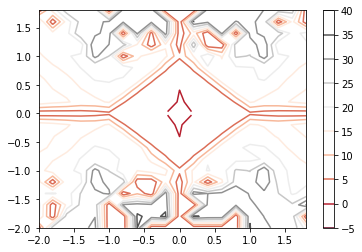

In [43]:
logf = np.frompyfunc(np.log, 1, 1)
logcorr = logf(corr)
plt.contour(Jy, Jz, logcorr, cmap='RdGy')
plt.colorbar()

Text(0, 0.5, 'Jz')

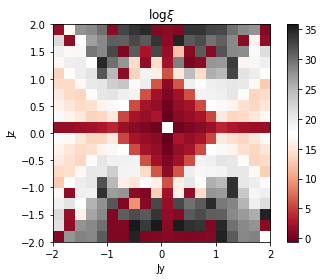

In [52]:
logcorr = np.vstack(logcorr[:, :]).astype(np.float)
Z = logcorr
plt.imshow(Z, extent=[-2, 2, -2, 2], origin='lower',
           cmap='RdGy')
plt.colorbar()
plt.axis(aspect='image')
plt.title(r"$\log \xi$")
plt.xlabel('Jy')
plt.ylabel('Jz')

## Extract the data

Here we extract the data into corresponding containers (lists)
Also some necessary preprocessing will be done here

In [ ]:
psi_list = data['psi_list']
entropy_list = [np.mean(psi.entanglement_entropy()) for psi in psi_list]
correlation_list = [psi.correlation_length() for psi in psi_list]

## Statistics

Do the fitting

In [ ]:
log_chi = np.log(correlation_list)
S = entropy_list

def func(log_chi, c, a):
    return (c / 6) * log_chi + a

fitParams, fitCovariances = curve_fit(func, log_chi, S)

## Plot the data

In [ ]:
plt.plot(log_chi, S, 'o')
plt.plot(log_chi, func(log_chi, fitParams[0], fitParams[1]), label=(r'$ S = \frac{%.2f}{6} \log\chi + %.2f $' % (fitParams[0], fitParams[1])))
plt.xlabel(r'$\log\chi$')
plt.ylabel(r'$S$')
plt.legend()
plt.title('Finite Engtanglement Scaling')
plt.show()

## Finite Entanglement Scaling
The below content only works for the gapless cases

In [ ]:
# from scipy.optimize import curve_fit

# def func(xi, c, a):
#     return (c / 6) * np.log(xi) + a

In [ ]:
# xi = correlation_list
# log_xi = np.log(correlation_list)
# s = entropy_list
# fitParams, fitCovariances = curve_fit(func, xi, s)

In [ ]:
# fitCovariances